# 0.0 Imports

In [4]:
import math
import numpy  as np
import pandas as pd
import inflection
import seaborn as sns
import xgboost as xgb
import requests
import warnings
import pickle
import random

from boruta                import BorutaPy
from sklearn.ensemble      import RandomForestRegressor
from scipy                 import stats  as ss
from matplotlib            import pyplot as plt
from IPython.display       import Image
from IPython.core.display  import HTML
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics       import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error 
from sklearn.linear_model  import LinearRegression, Lasso

warnings.filterwarnings( 'ignore' )

### 0.1 Helper functions

In [5]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
def cramer_v(x,y):
    cm = pd.crosstab(x, y).values
    
    n = cm.sum()

    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0,chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n)/(min(kcorr-1,rcorr-1)))
    
    
def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y,yhat)
    mape = mean_absolute_percentage_error(y,yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'model name': model_name, 'MAE': mae, 'MAPE':mape, 'RMSE':rmse}, index=[0])


def cross_validation(x_training, kfold, model_name, model, verbose=False):

    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed(range(1,kfold+1)):
        
        if verbose:
            print('\nKfold number: {}'.format(k))

        # start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)

        # filterin dataset
        training = x_training[x_training['date']<validation_start_date]
        validation = x_training[(x_training['date']>=validation_start_date) & (x_training['date']<=validation_end_date)]

        # training and validation dataset
        xtraining = training.drop(['date','sales'], axis=1)
        ytraining = training['sales']

        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']

        # model 
        m = model.fit(xtraining, ytraining)

        # prediction
        yhat = m.predict(xvalidation)

        # performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))
        
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame({'Model Name': model_name,
             'MAE CV': np.round(np.mean(mae_list),2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
             'MAPE CV': np.round(np.mean(mape_list),2).astype(str) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str),
             'RMSE CV': np.round(np.mean(rmse_list),2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str)}, index=[0])

### 0.2 Loading data

In [6]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


In [7]:
df_sales_raw = pd.read_csv('train.csv', low_memory=False)
df_store_raw = pd.read_csv('store.csv', low_memory=False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# 1.0 Descrição dos dados

In [8]:
df1 = df_raw.copy()

### 1.1 Rename columns

In [9]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 
            'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
            'StoreType', 'Assortment','CompetitionDistance',
            'CompetitionOpenSinceMonth','CompetitionOpenSinceYear', 
            'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

# renomeando as colunas com snakecase
snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase,cols_old))
df1.columns=cols_new

### 1.2 Data dimensions

In [10]:
print('Numero de linhas: {}'.format(df1.shape[0]))
print('Numero de colunas: {}'.format(df1.shape[1]))

Numero de linhas: 1017209
Numero de colunas: 18


### 1.3 Data types

In [11]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

### 1.4 Check NA

In [12]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

### 1.5 Fill the NA

In [13]:
# competition_distance
df1['competition_distance']= df1['competition_distance'].apply(lambda x: 200000 if math.isnan(x) else x)

# competition_open_since_month 
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

# competition_open_since_year 
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

# promo2_since_week 
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

# promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

# promo_interval
month_map = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',
             7: 'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval']==0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [14]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

### 1.6 Change types

In [15]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [16]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)

df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)

df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

### 1.7 Descriptive Statistical

#### Numerical attributes

In [17]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])

cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

In [18]:
# tendencia central
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T

ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# disperssão
d1 = pd.DataFrame(num_attributes.apply(np.std)).T

d2 = pd.DataFrame(num_attributes.apply(min)).T

d3 = pd.DataFrame(num_attributes.apply(max)).T

d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max()-x.min())).T

d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
                  
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurt())).T

# concatenando
m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

In [19]:
m

attributes     min       max     range         mean  median           std       skew    kurtosis
0                          store     1.0    1115.0    1114.0   558.429727   558.0    321.908493  -0.000955   -1.200524
1                    day_of_week     1.0       7.0       6.0     3.998341     4.0      1.997390   0.001593   -1.246873
2                          sales     0.0   41551.0   41551.0  5773.818972  5744.0   3849.924283   0.641460    1.778375
3                      customers     0.0    7388.0    7388.0   633.145946   609.0    464.411506   1.598650    7.091773
4                           open     0.0       1.0       1.0     0.830107     1.0      0.375539  -1.758045    1.090723
5                          promo     0.0       1.0       1.0     0.381515     0.0      0.485758   0.487838   -1.762018
6                 school_holiday     0.0       1.0       1.0     0.178647     0.0      0.383056   1.677842    0.815154
7           competition_distance    20.0  200000.0  199980.0  5935.442677  2330.0  12547.646829  10.242344  147.789712
8   competition_open_since_month     1.0      12.0      11.0     6.786849     7.0      3.311085  -0.042076   -1.232607
9    competition_open_since_year  1900.0    2015.0     115.0  2010.324840  2012.0      5.515591  -7.235657  124.071304
10                        promo2     0.0       1.0       1.0     0.500564     1.0      0.500000  -0.002255   -1.999999
11             promo2_since_week     1.0      52.0      51.0    23.619033    22.0     14.310057   0.178723   -1.184046
12             promo2_since_year  2009.0    2015.0       6.0  2012.793297  2013.0      1.662657  -0.784436   -0.210075
13                      is_promo     0.0       1.0       1.0     0.165966     0.0      0.372050   1.795644    1.224338

<AxesSubplot:ylabel='Density'>

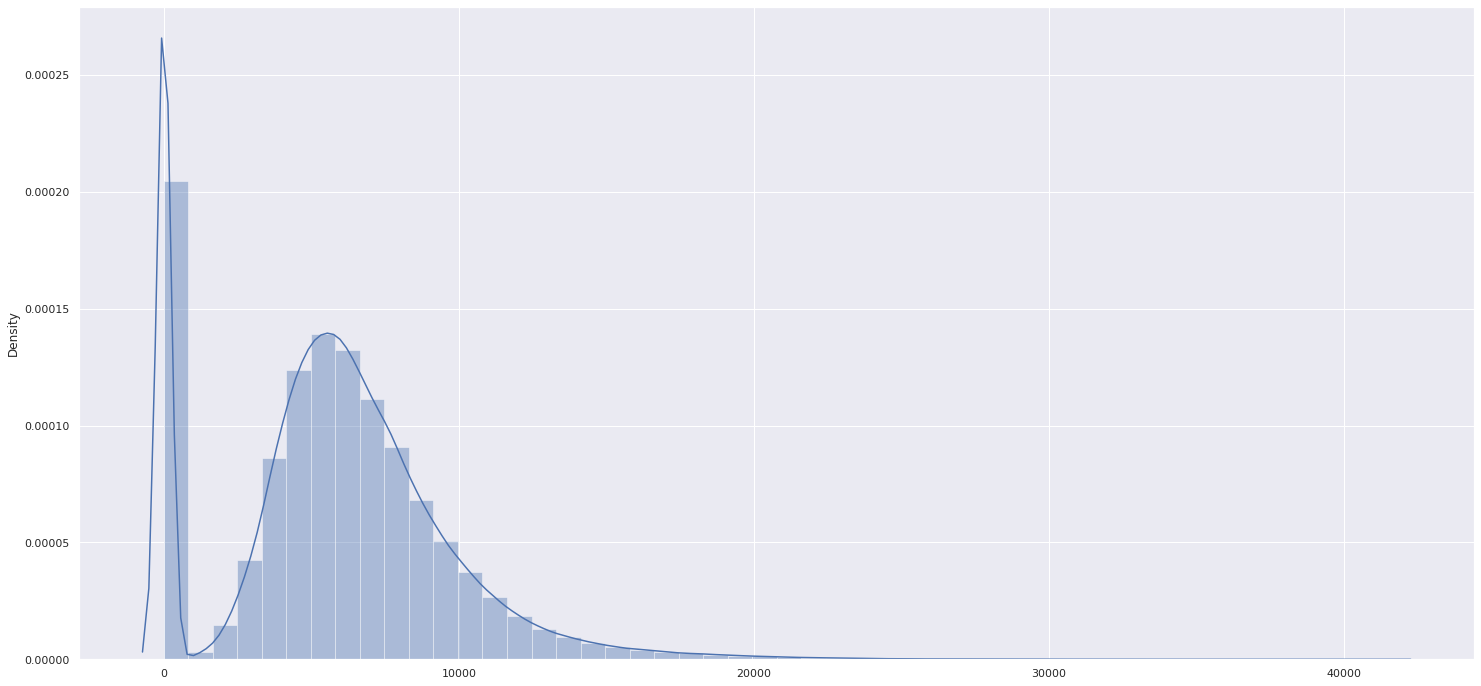

In [20]:
sns.distplot([df1['sales']])

#### Categorical attributes

In [21]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

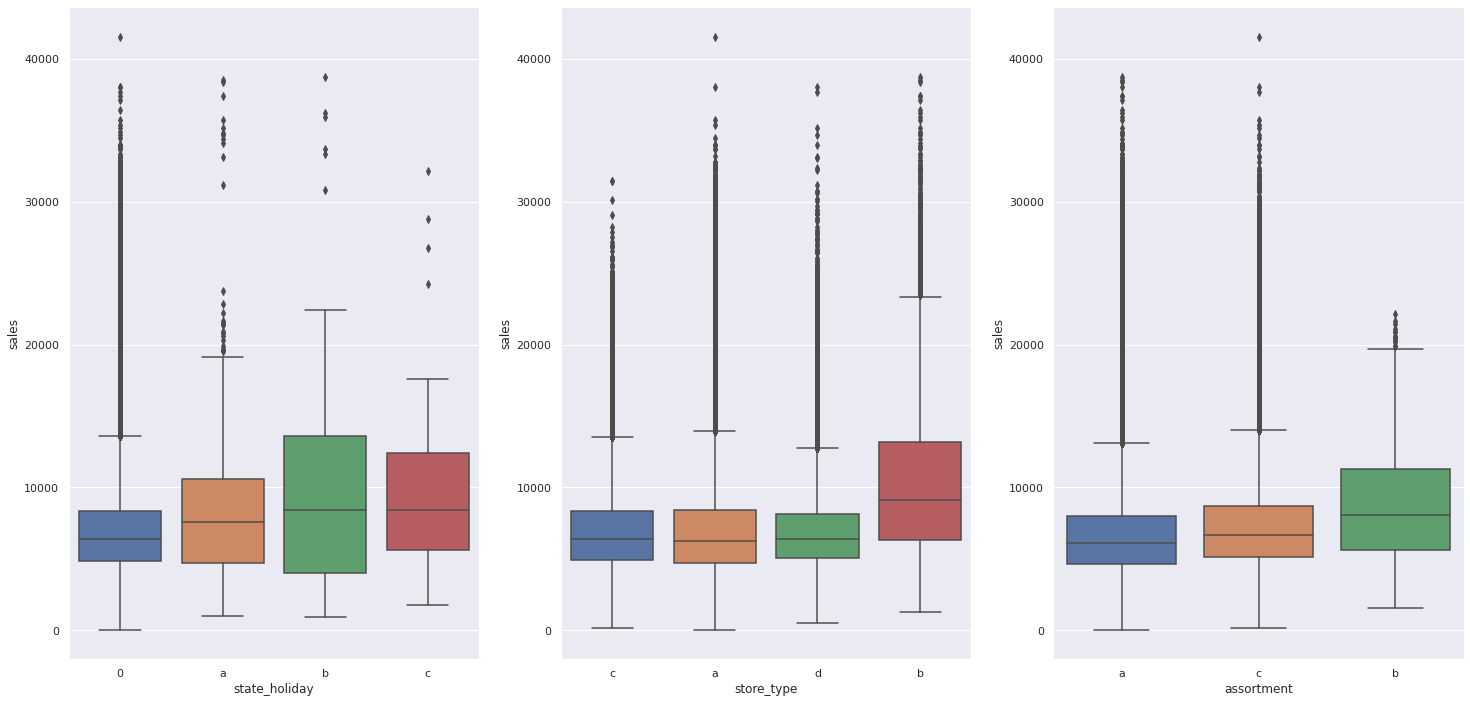

In [22]:
# tirando od dias de lojas fechadas e dias que nao tiveram vendas
aux1 = df1[(df1['state_holiday'] != 0) & (df1['sales']>0)]

plt.subplot(1,3,1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.boxplot(x='assortment', y='sales', data=aux1)

# 2.0 Feature engineering

In [23]:
df2 = df1.copy()

### 2.1 Mind map 

### 2.2 Criação das hipóteses

#### Hipóteses relacionadas as lojas

1 - Lojas com maior quadro de funcionários deveriam vender mais

2 - Lojas com maior estoque deveriam vender mais

3 - Lojas com maior porte deveriam vender mais

4 - Lojas com menor porte deveriam vender menos

5 - Lojas com maior sortimento deveriam vender mais

#### Hipóteses relacionadas ao produto

1 - Lojas que investem mais em marketing deveriam vender mais

2 - Lojas que expõe mais os produtos nas vitrines deveriam vender mais 

3 - Lojas que tem preços menores nos produtos deveriam vender mais 

4 - Lojas que tem preços menores por mais tempo deveriam vender mais 

#### Hipóteses relacionadas ao tempo

1 - Lojas que tem mais feriados deveriam vender menos

2 - Lojas que abrem nos primeiros 6 meses deveriam vender mais

3 - Lojas que abrem nos finais de semana deveriam vender mais 

### 2.3 Lista final de hipóteses

Focal5 - Lojas com maior sortimento deveriam vender mais

6 - Lojas com competidores mais próximos deveriam vender menos

7 - Lojas com competidores a mais tempo deveriam vender mais 

8 - Lojas com promoções ativas por mais tempo deveriam vender mais

9 - Lojas com mais dias de promoção deveriam vender mais 

10 - Lojas com promoções consecutivas deveriam vender mais 

11 - Lojas abertas durante o feriado de natal deveriam vender mais 

12 - Lojas deveriam vender mais ao longo dos anos

13 - Lojas deveriam vender mais no segundo semestre do ano

14 - Lojas deveriam vender mais depois do dia 10 de cada mês 

15 - Lojas deveriam vender menos nos finais de semana

16 - Lojas deveriam vender menos durante os feriados escolares



### 2.4 Feature engineering

In [24]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day 
df2['day'] = df2['date'].dt.day

# week of ywar
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime(year = x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)

df2['competition_time_month']= ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)

df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x+'-1', '%Y-%W-%w') - datetime.timedelta(days=7))

df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x=='a' else 'extra' if x=='b' else 'extend')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x=='a' else 'easter_holiday' if x=='b' else 'christmas' if x=='c' else 'regular_day') 

In [25]:
df2.head()

store  day_of_week       date  sales  customers  open  promo state_holiday  school_holiday store_type assortment  competition_distance  competition_open_since_month  competition_open_since_year  promo2  promo2_since_week  promo2_since_year   promo_interval month_map  is_promo  year  month  day  week_of_year year_week competition_since  competition_time_month promo_since  promo_time_week
0      1            5 2015-07-31   5263        555     1      1   regular_day               1          c      basic                1270.0                             9                         2008       0                 31               2015                0       Jul         0  2015      7   31            31   2015-30        2008-09-01                      84  2015-07-27                0
1      2            5 2015-07-31   6064        625     1      1   regular_day               1          a      basic                 570.0                            11                         2007       1                 13               2010  Jan,Apr,Jul,Oct       Jul         1  2015      7   31            31   2015-30        2007-11-01                      94  2010-03-22              279
2      3            5 2015-07-31   8314        821     1      1   regular_day               1          a      basic               14130.0                            12                         2006       1                 14               2011  Jan,Apr,Jul,Oct       Jul         1  2015      7   31            31   2015-30        2006-12-01                     105  2011-03-28              226
3      4            5 2015-07-31  13995       1498     1      1   regular_day               1          c     extend                 620.0                             9                         2009       0                 31               2015                0       Jul         0  2015      7   31            31   2015-30        2009-09-01                      71  2015-07-27                0
4      5            5 2015-07-31   4822        559     1      1   regular_day               1          a      basic               29910.0                             4                         2015       0                 31               2015                0       Jul         0  2015      7   31            31   2015-30        2015-04-01                       4  2015-07-27                0

# 3.0 Filtragem de variáveis

In [26]:
df3 = df2.copy()

### 3.1 Filtragem das linhas

In [27]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

### 3.2 Seleção das colunas

In [28]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

# 4.0 Análise exploratória de dados

In [29]:
df4 = df3.copy()

### 4.1 Análise univariada

#### Reponse variables

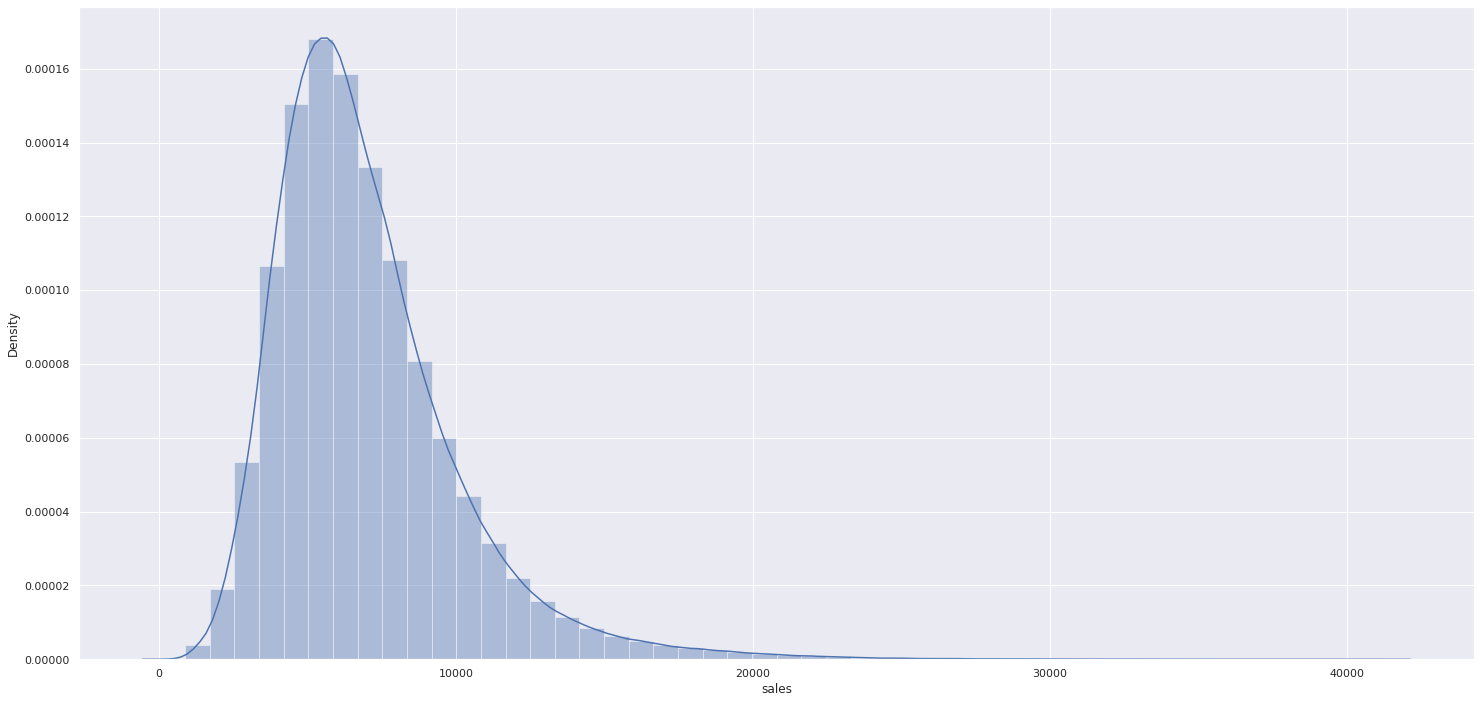

In [27]:
sns.distplot(df4['sales']);

#### Numerical variables

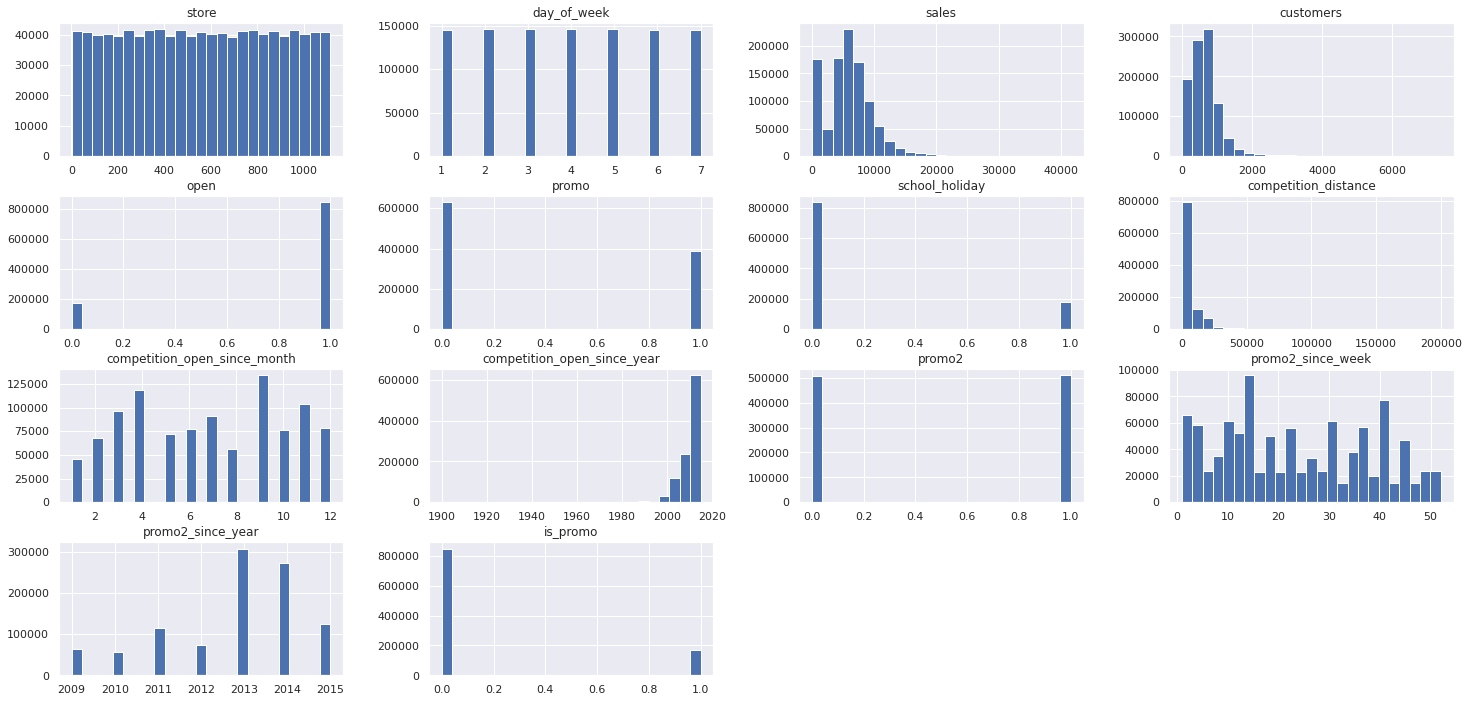

In [28]:
num_attributes.hist(bins=25);

#### Categorical variable

<AxesSubplot:xlabel='sales', ylabel='Density'>

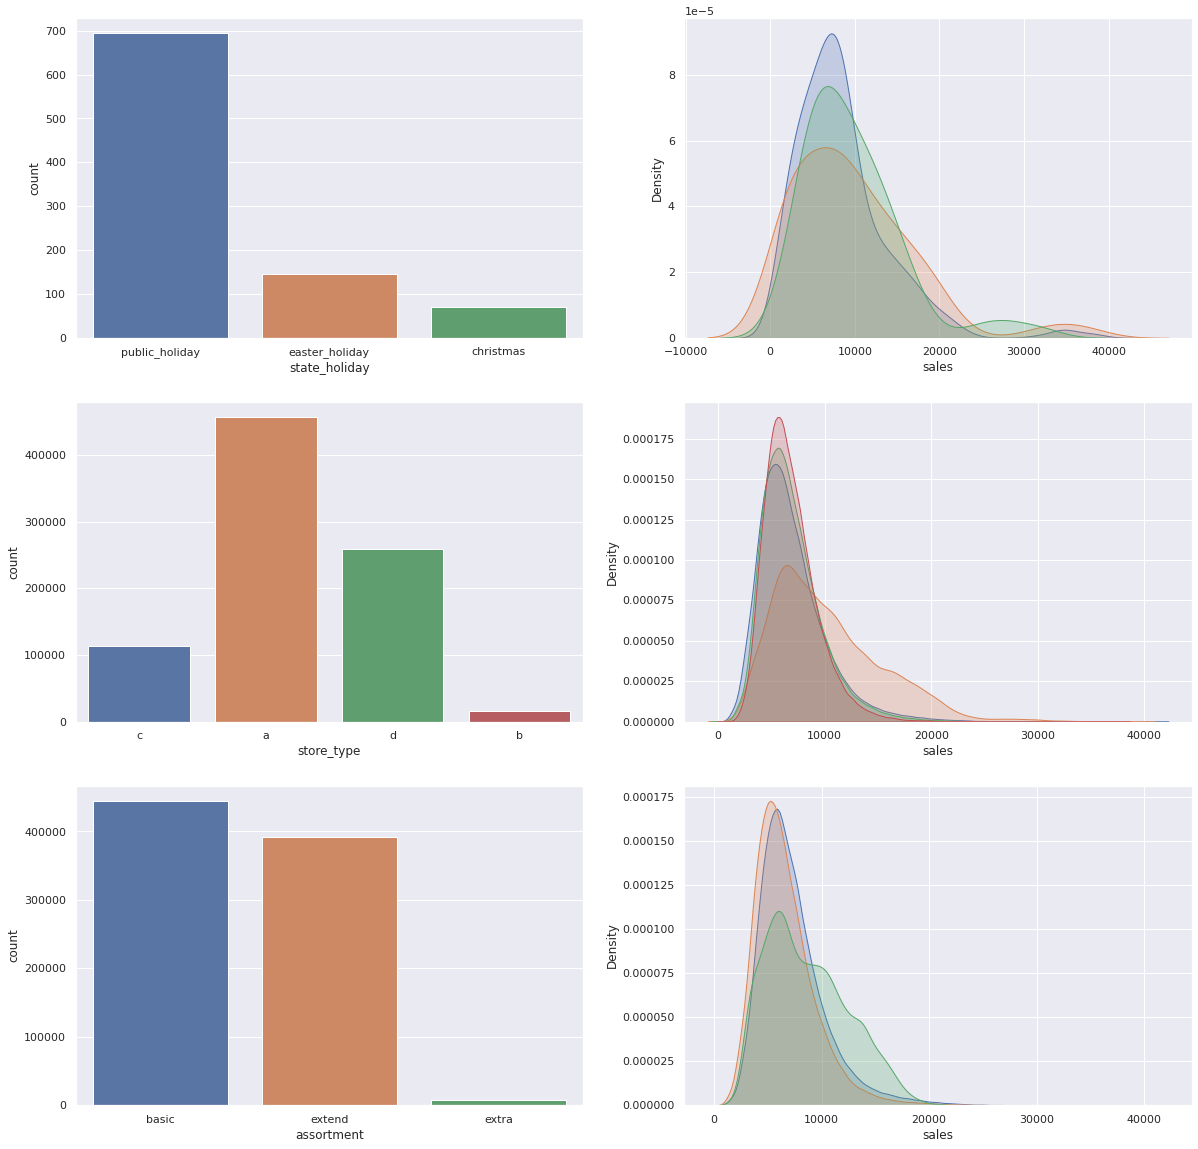

In [29]:
# state holiday
sns.set(rc={"figure.figsize":(20, 20)})
plt.subplot(3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] =='public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] =='easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] =='christmas']['sales'], label='christmas', shade=True)

# store type
plt.subplot(3, 2, 3)
sns.countplot(df4['store_type'])

plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4['store_type'] =='a']['sales'], label='a', shade=True)
sns.kdeplot(df4[df4['store_type'] =='b']['sales'], label='b', shade=True)
sns.kdeplot(df4[df4['store_type'] =='c']['sales'], label='c', shade=True)
sns.kdeplot(df4[df4['store_type'] =='d']['sales'], label='d', shade=True)

# assortment
plt.subplot(3, 2, 5)
sns.countplot(df4['assortment'])

plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['assortment'] =='extend']['sales'], label='extend', shade=True)
sns.kdeplot(df4[df4['assortment'] =='basic']['sales'], label='basic', shade=True)
sns.kdeplot(df4[df4['assortment'] =='extra']['sales'], label='extra', shade=True)


### 4.2 Análise bivariada

#### H1 - Lojas com maior sortimentos deveriam vender mais.

**FALSA** Lojas com MAIOR SORTIMENTO vendem MENOS.


<AxesSubplot:xlabel='year_week'>

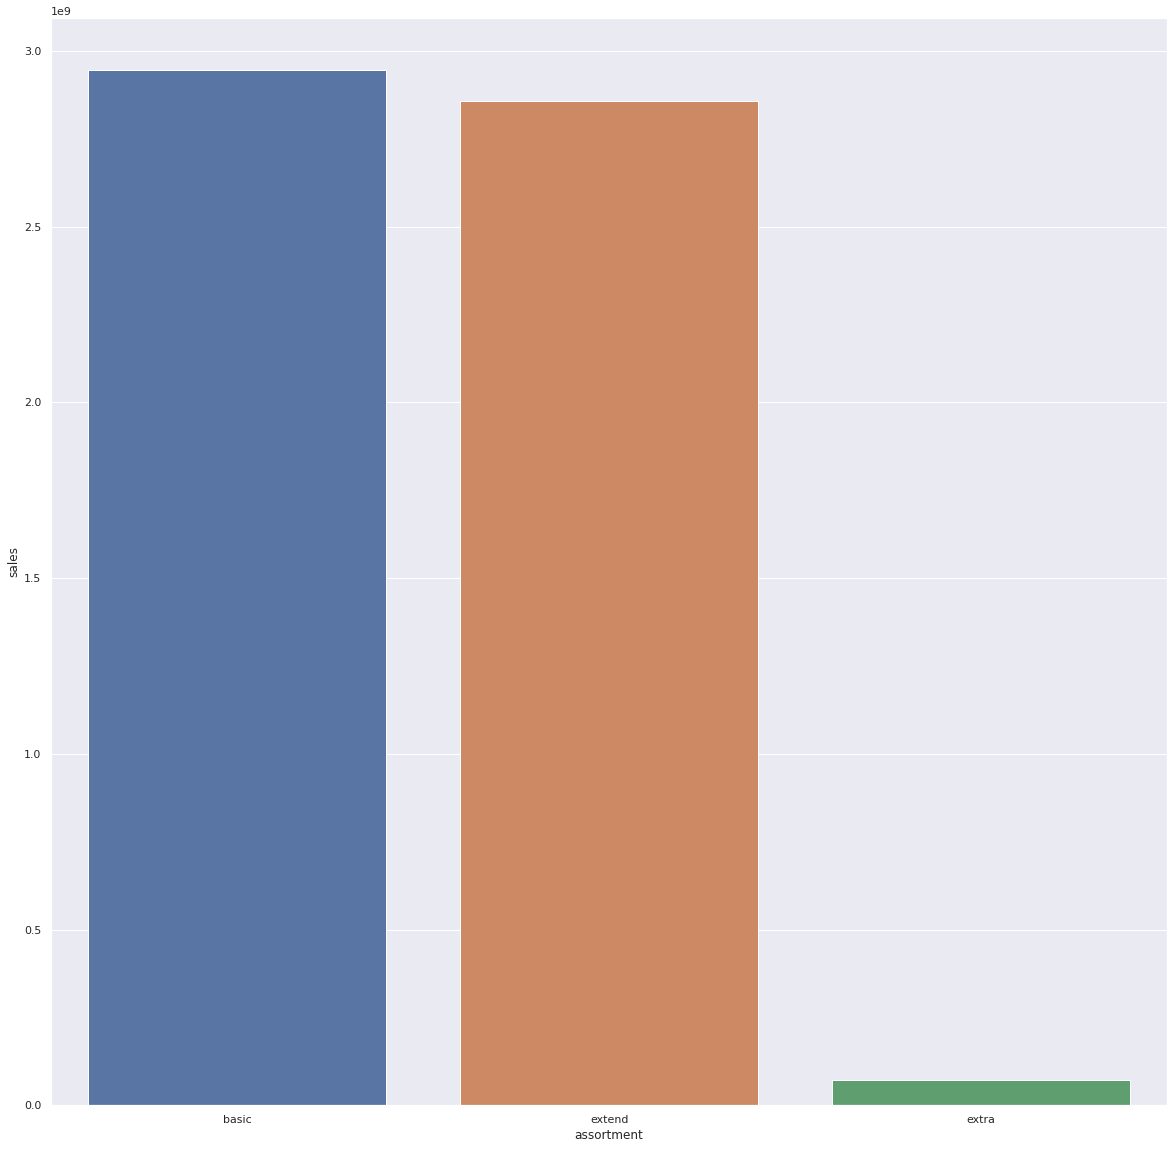

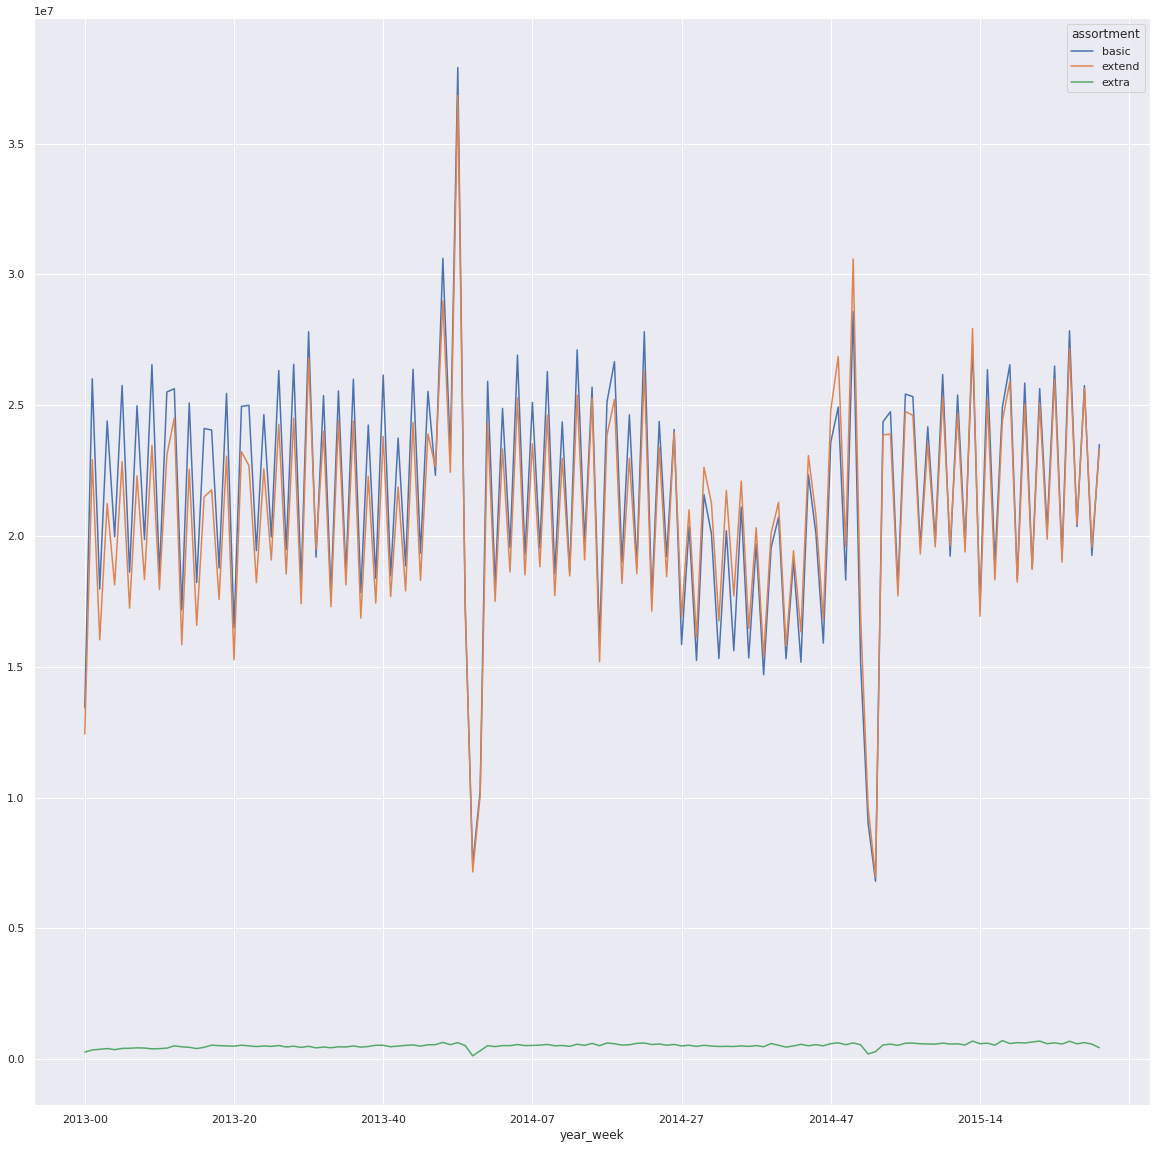

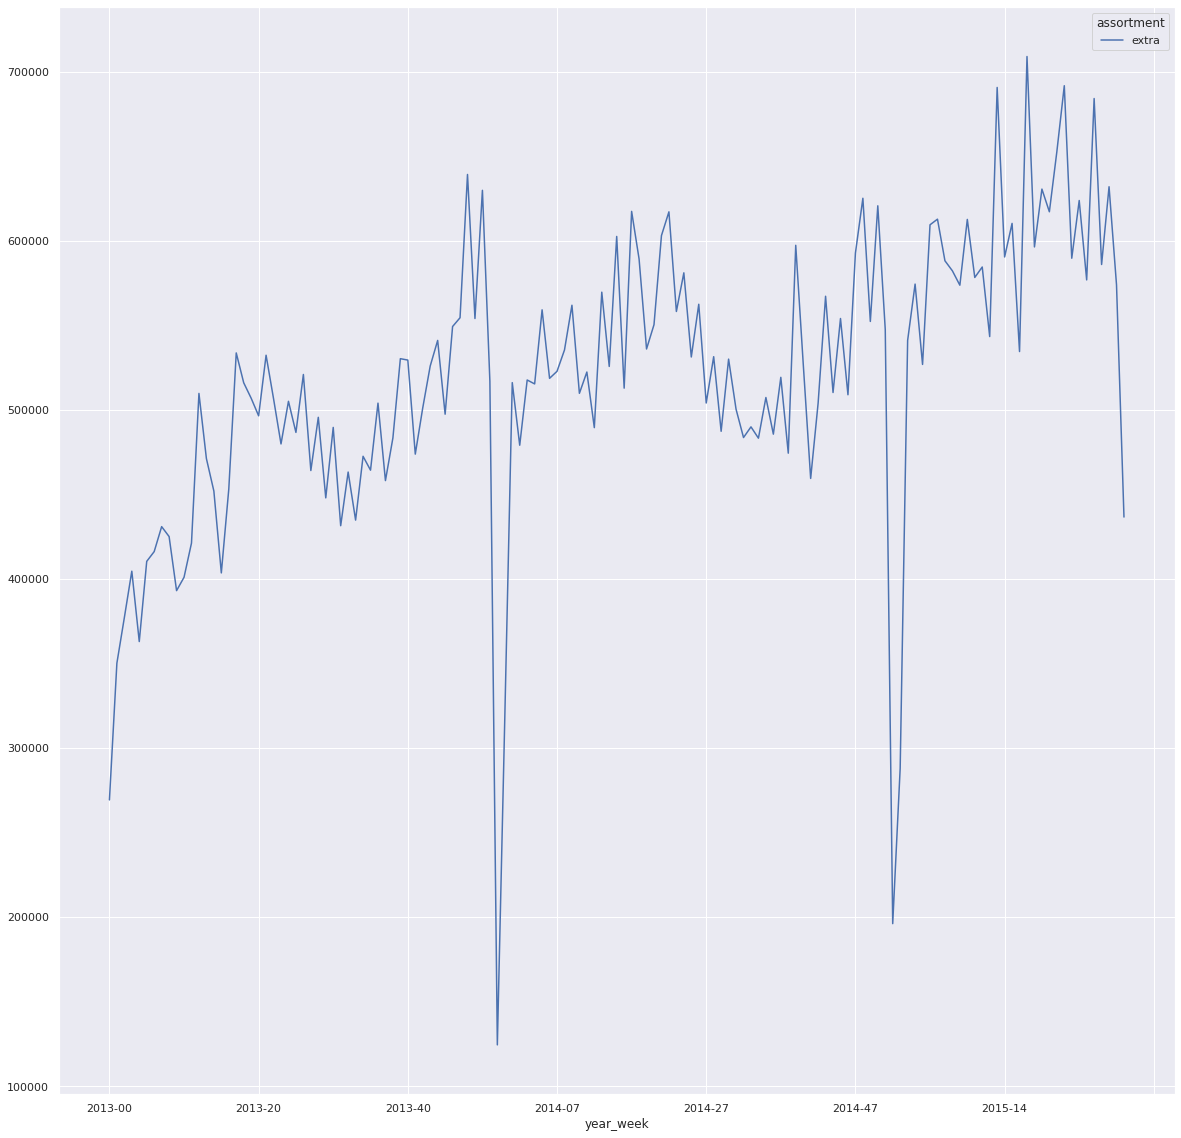

In [30]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment',y='sales', data=aux1)

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()

aux3 = aux2[aux2['assortment']=='extra']
aux3.pivot( index='year_week', columns='assortment', values='sales' ).plot()

#### H2 - Lojas com competidores mais próximos deveriam vender menos

**FALSA** Lojas com competidores mais proximos vendem mais 

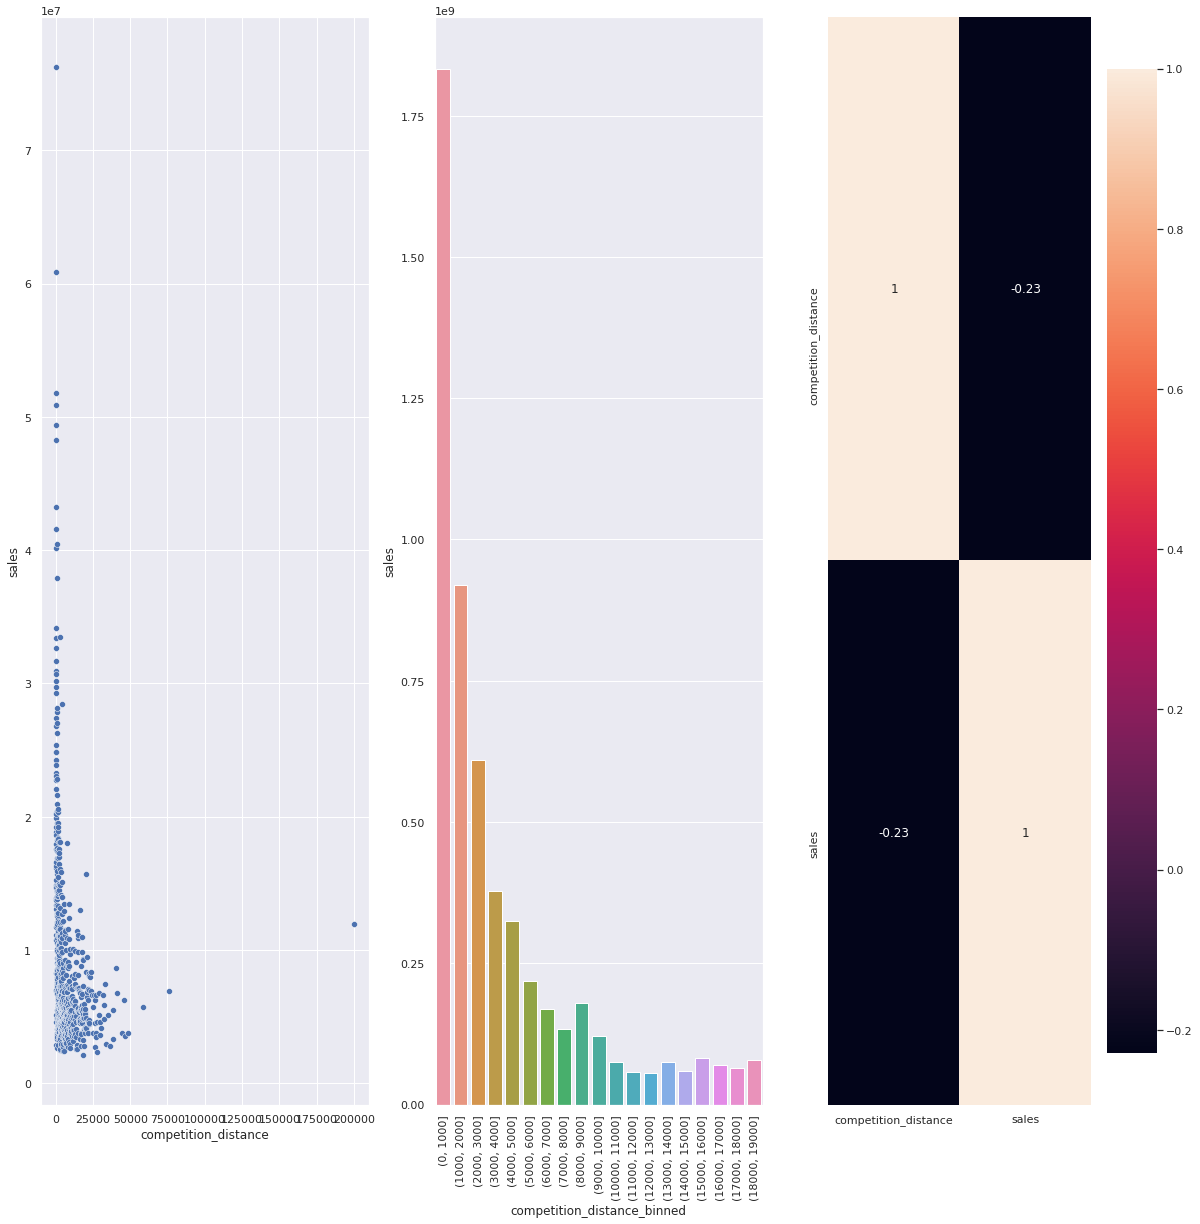

In [31]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1,3,1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1);

plt.subplot(1,3,2)
bins = list(np.arange (0,20000,1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);
plt.xticks(rotation=90)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True);

#### H3 - Lojas com competidores a mais tempo deveriam vender mais 

**FALSA** Lojas com competidores a mais tempo vendem menos 

<AxesSubplot:>

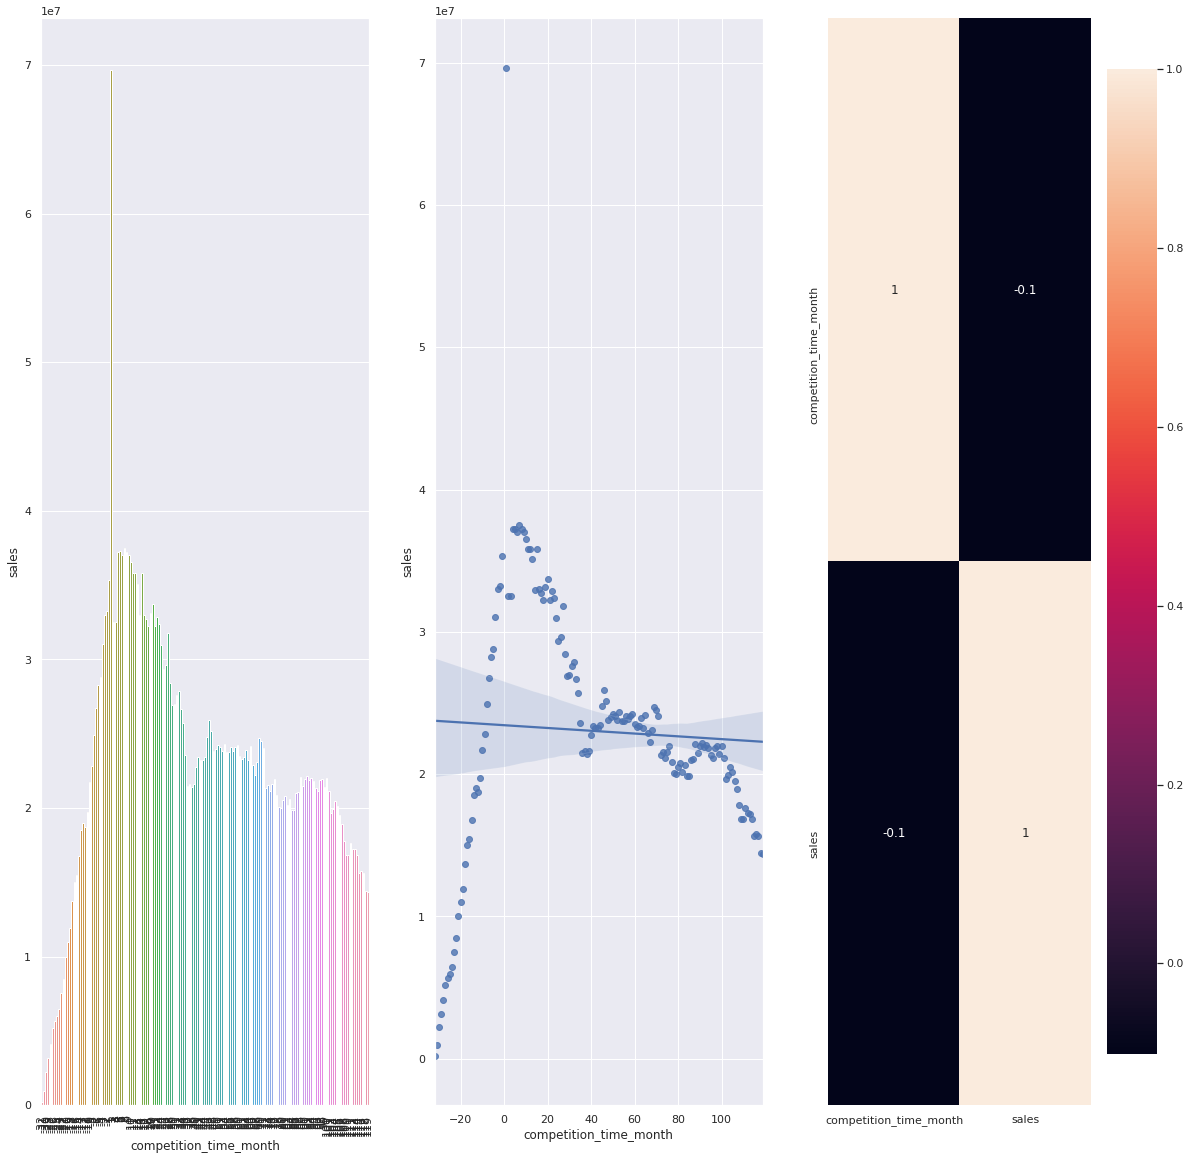

In [32]:
plt.subplot(1,3,1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month']<120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x='competition_time_month', y='sales', data=aux2)
plt.xticks(rotation=90)

plt.subplot(1,3,2)
sns.regplot(x='competition_time_month', y='sales', data=aux2)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

#### H4 - Lojas com promoções ativas a mais tempo deveriam vender mais

**FALSA** Lojas com promoções ativas por mais tempo vendem menos, depois de um certo período de promoção

<AxesSubplot:>

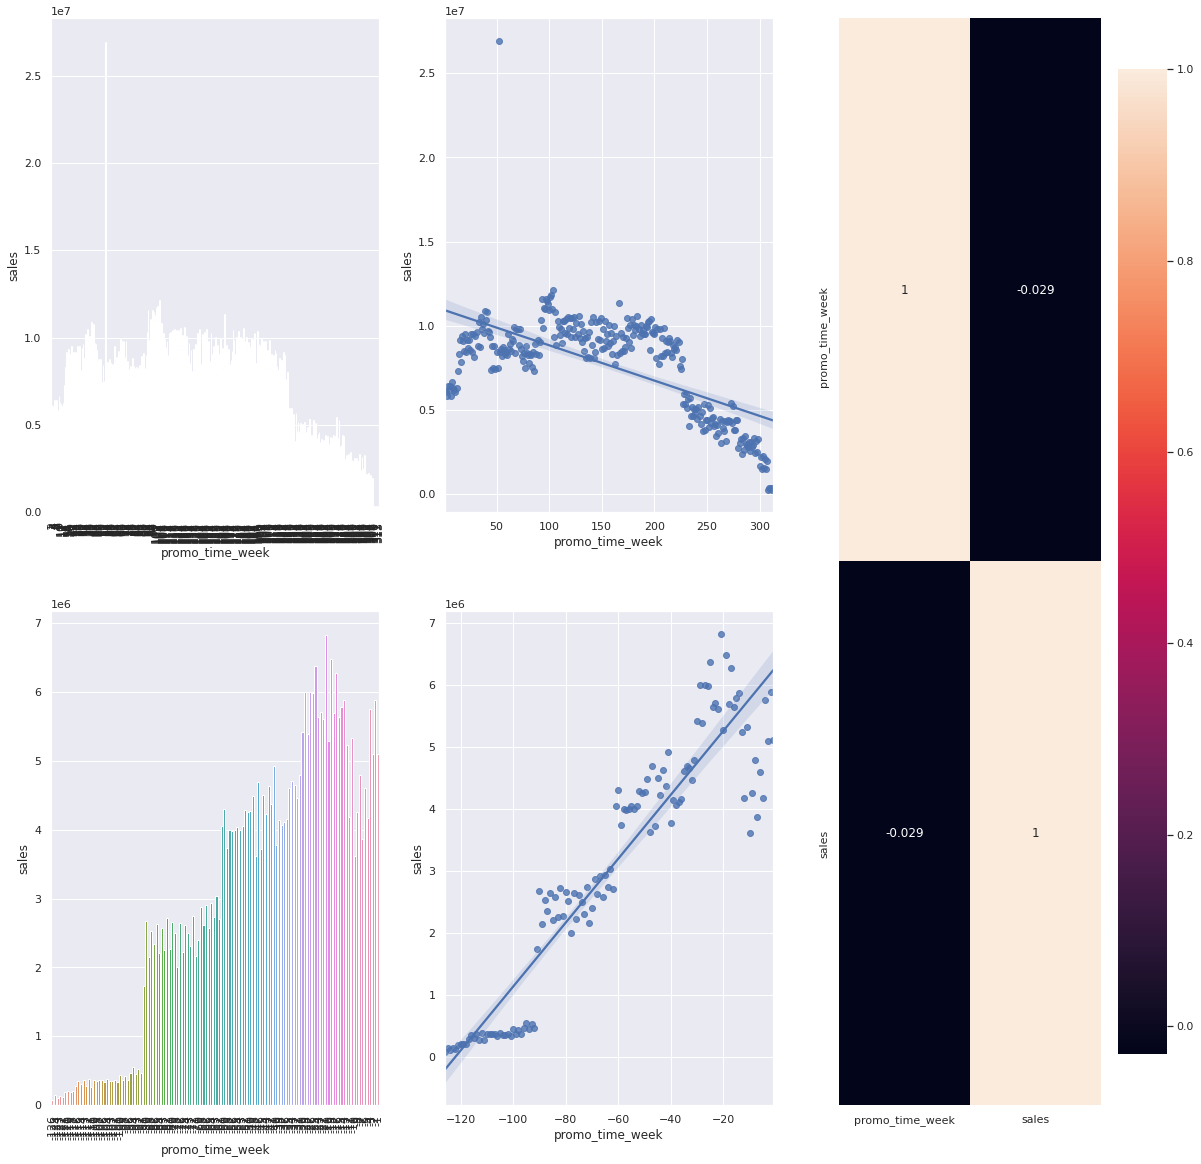

In [33]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec(2,3)

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week']>0] # promocao extentida
sns.barplot(x='promo_time_week', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week', y='sales', data=aux2);

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week']<0] # promocao regular
sns.barplot(x='promo_time_week', y='sales', data=aux3);
plt.xticks(rotation=90);

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week', y='sales', data=aux3);

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'), annot=True)

#### <s>H5 - Lojas com mais dias de promoção deveriam vender mais</s>  

#### H6 - Lojas com promoções consecutivas deveriam vender mais 

**FALSA** Lojas com mais promoções consecutivas vendem menos

In [34]:
df4[['promo', 'promo2', 'sales']].groupby(['promo','promo2']).sum().reset_index()

promo  promo2       sales
0      0       0  1482612096
1      0       1  1289362241
2      1       0  1628930532
3      1       1  1472275754

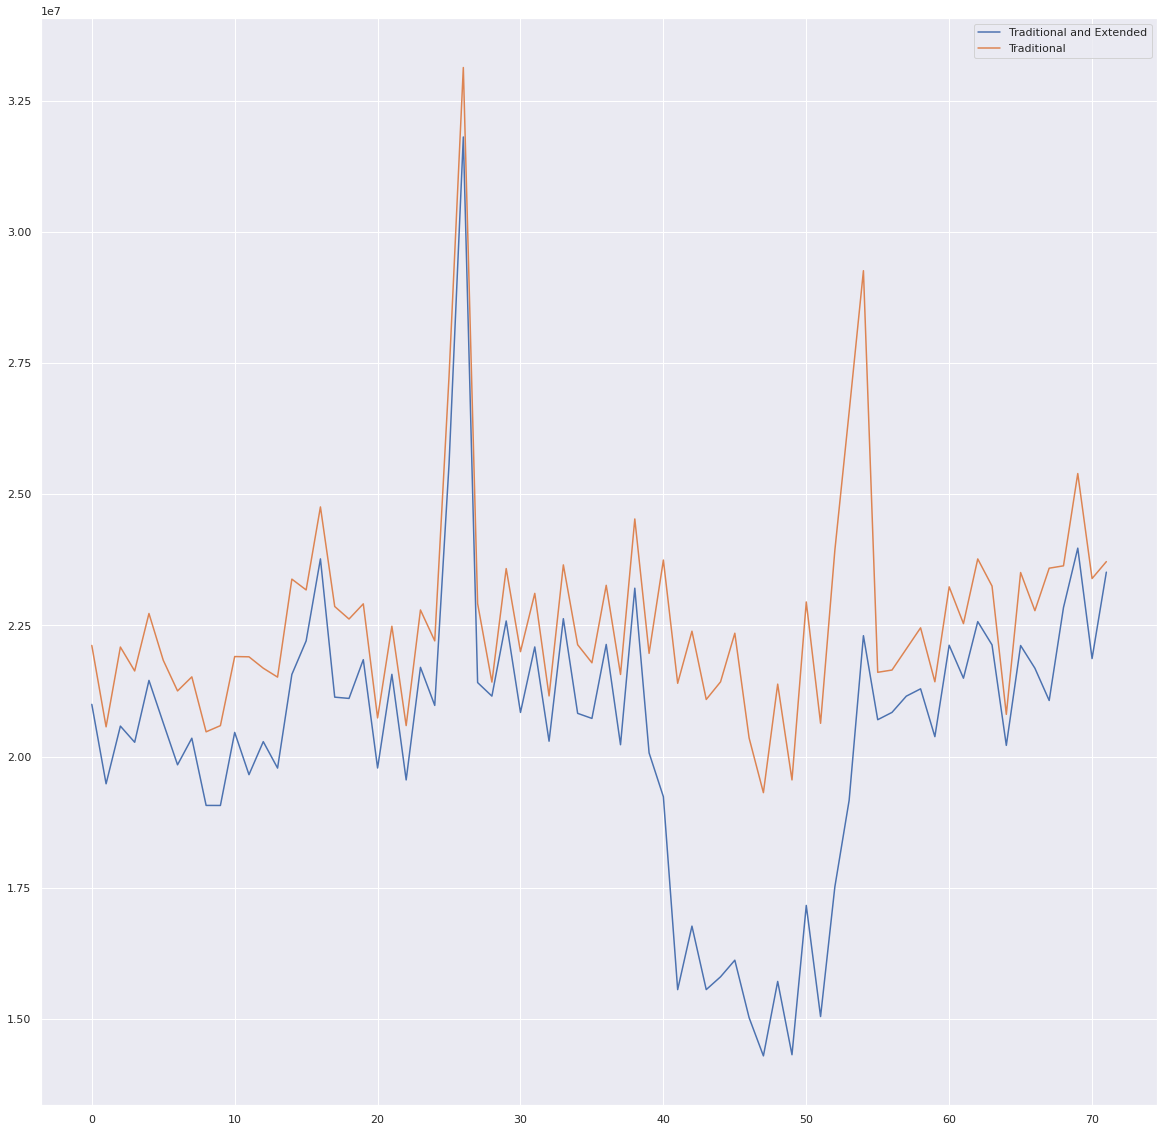

In [35]:
aux1= df4[(df4['promo']==1) & (df4['promo2']==1)][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2= df4[(df4['promo']==1) & (df4['promo2']==0)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['Traditional and Extended', 'Traditional'])

#### H7 - Lojas abertas durante o feriado de Natal deveriam vender mais 

**FALSA** Lojas abertas durante o feridado Natal vendem menos

<AxesSubplot:xlabel='year', ylabel='sales'>

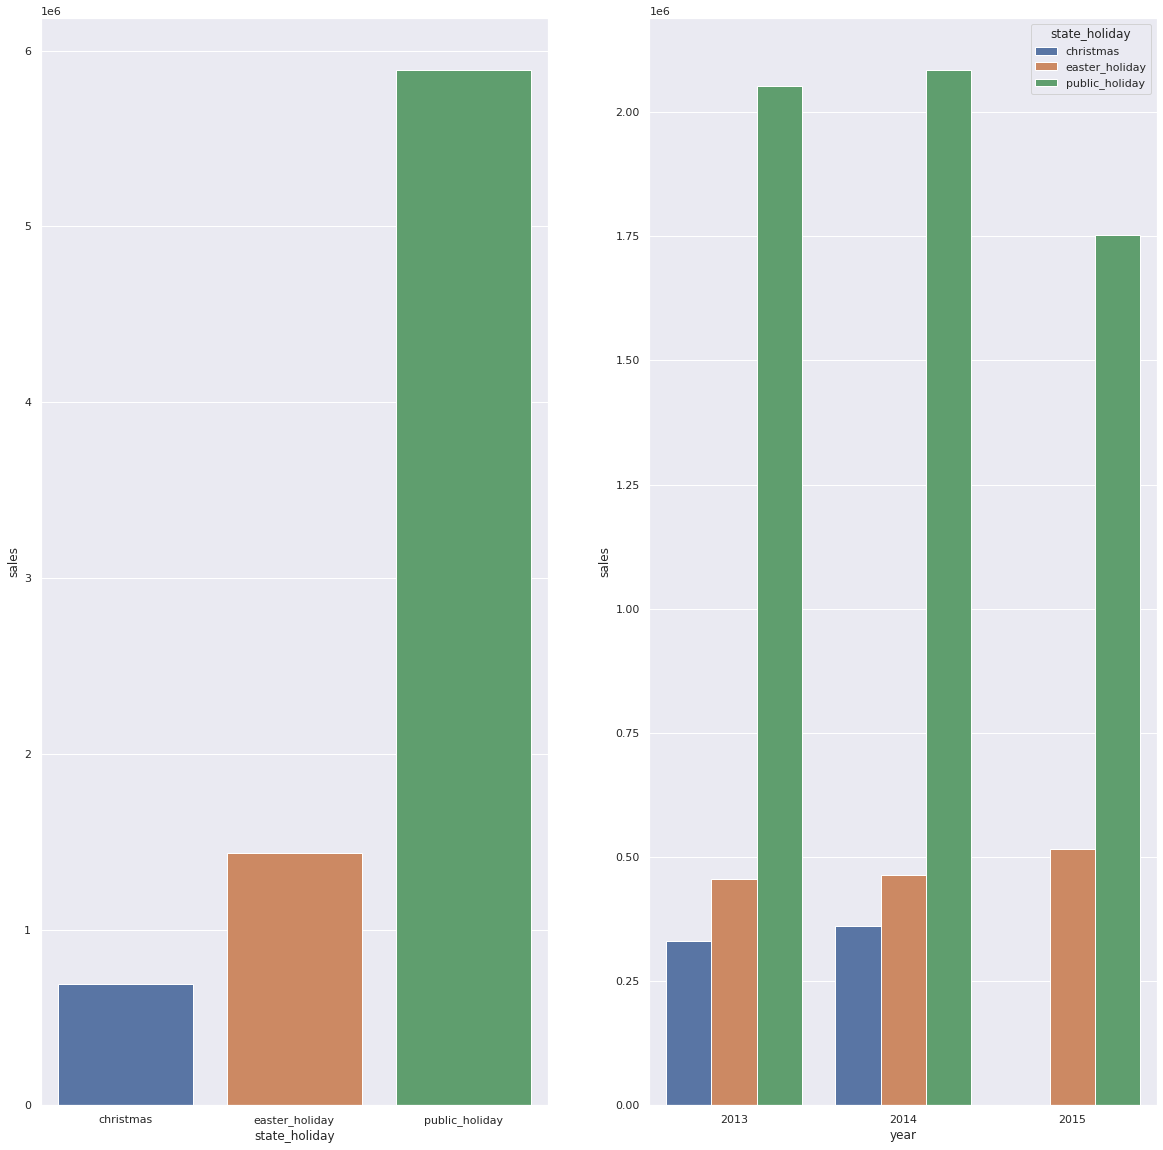

In [36]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1,2,1)
aux1 = aux[['state_holiday','sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1,2,2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2)

#### H8 - Lojas deveriam vender mais ao longo dos anos

**FALSA** Lojas vendem menos ao longo dos anos

<AxesSubplot:>

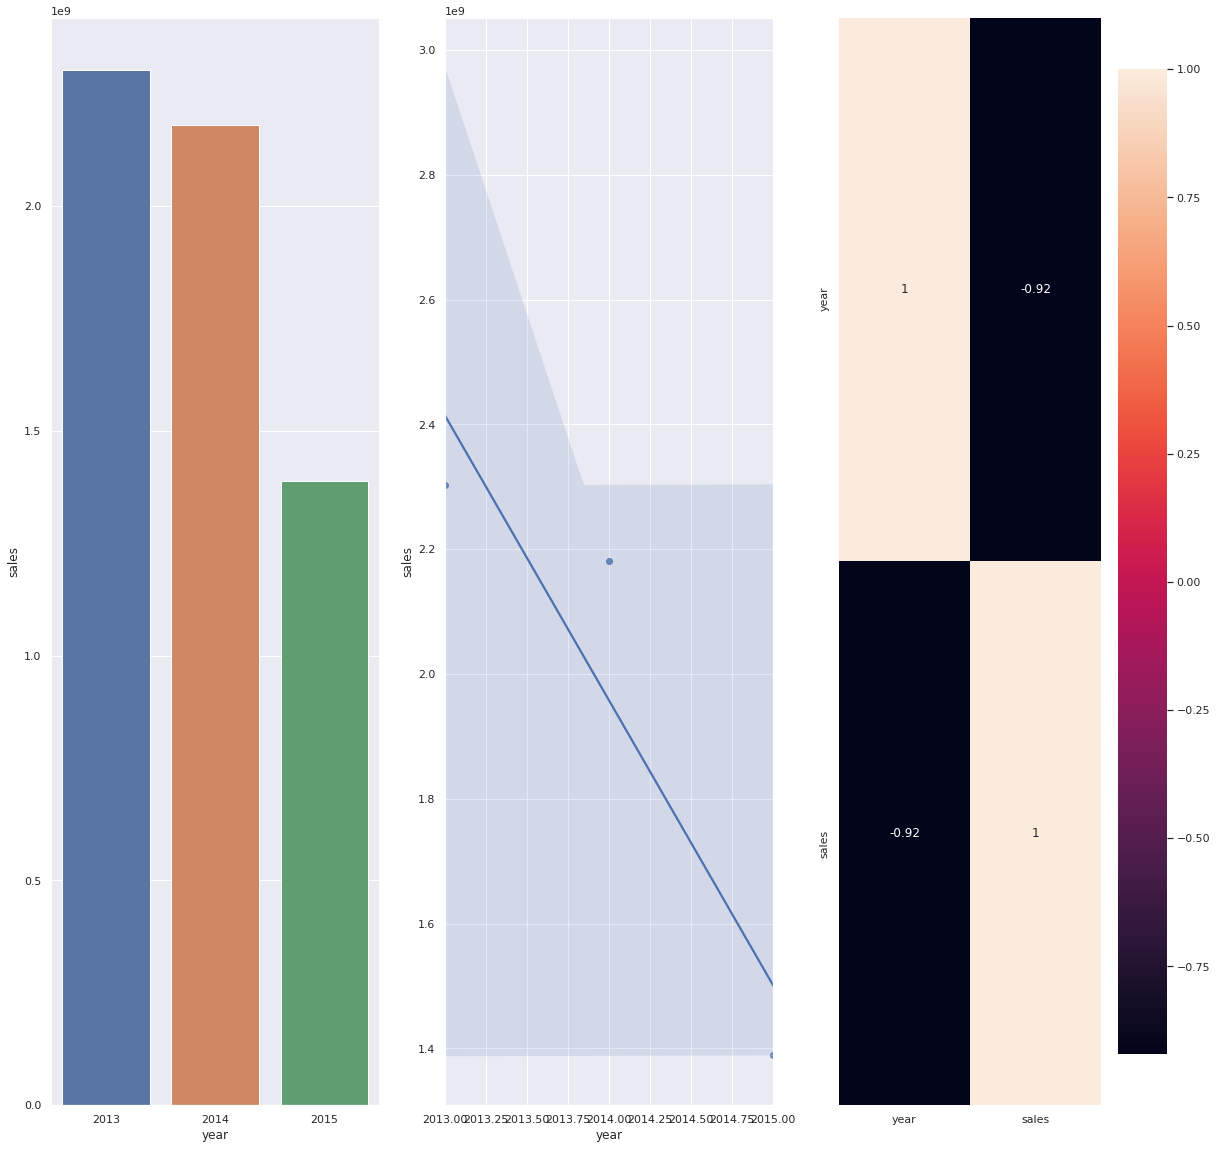

In [37]:
aux1 = df4[['year','sales']].groupby('year').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='year', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.regplot(x='year', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

#### H9 - Lojas deveriam vender mais no segundo semestre do ano

**FALSA** Lojas vendem menos no segundo semestre do ano

<AxesSubplot:>

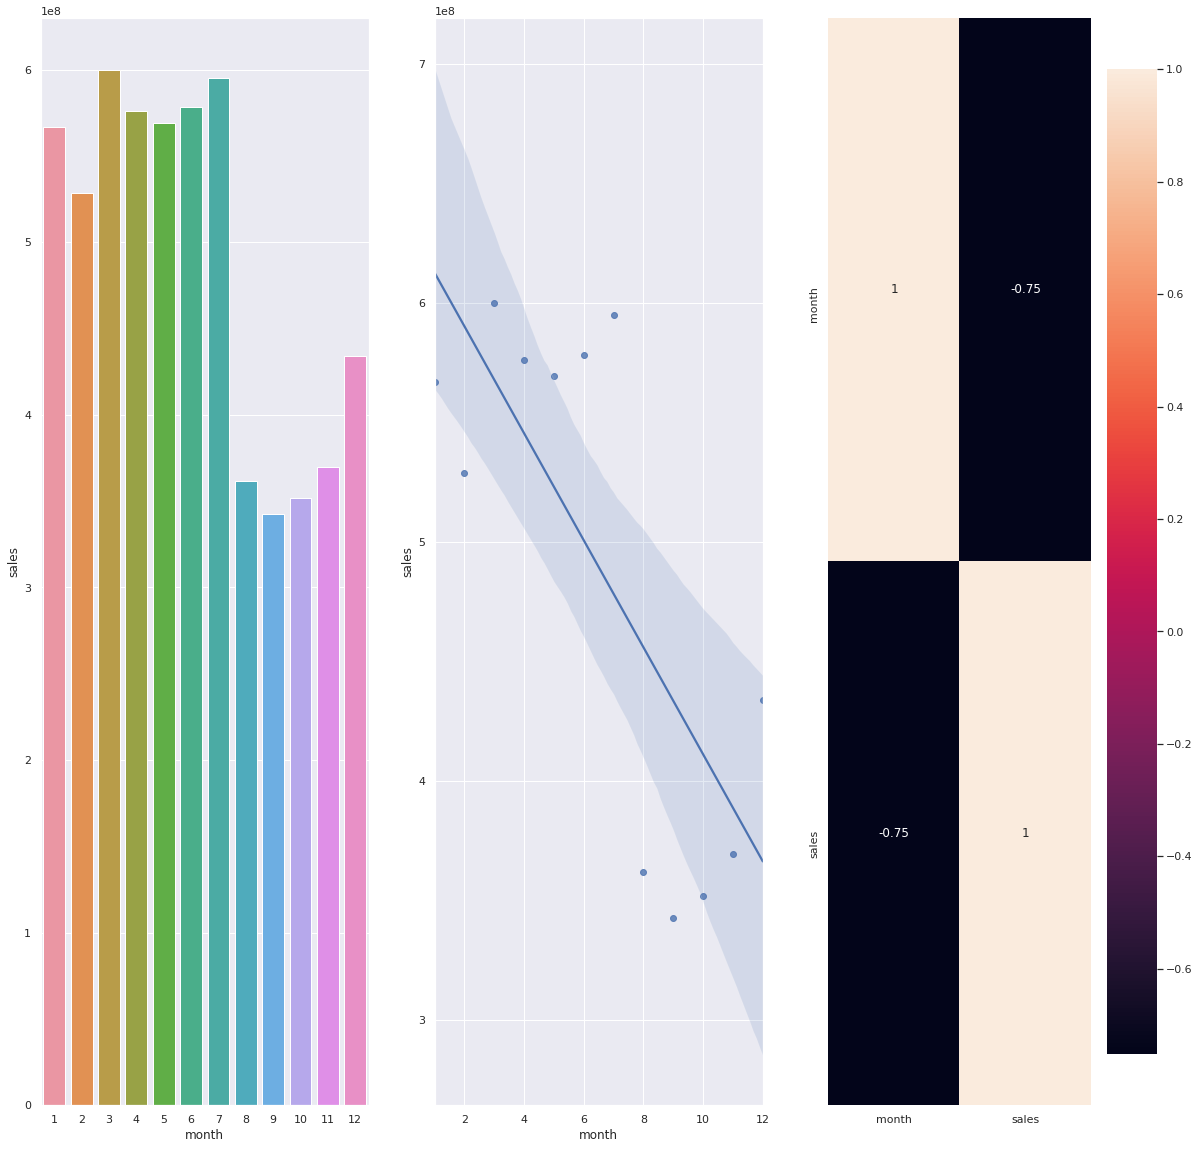

In [38]:
aux1 = df4[['month','sales']].groupby('month').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='month', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.regplot(x='month', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

#### H10 - Lojas deveriam vender mais depois do dia 10 de cada mês

**VERDADEIRA** Lojas vendem mais depois do dia 10 de cada mês

<AxesSubplot:xlabel='before_after', ylabel='sales'>

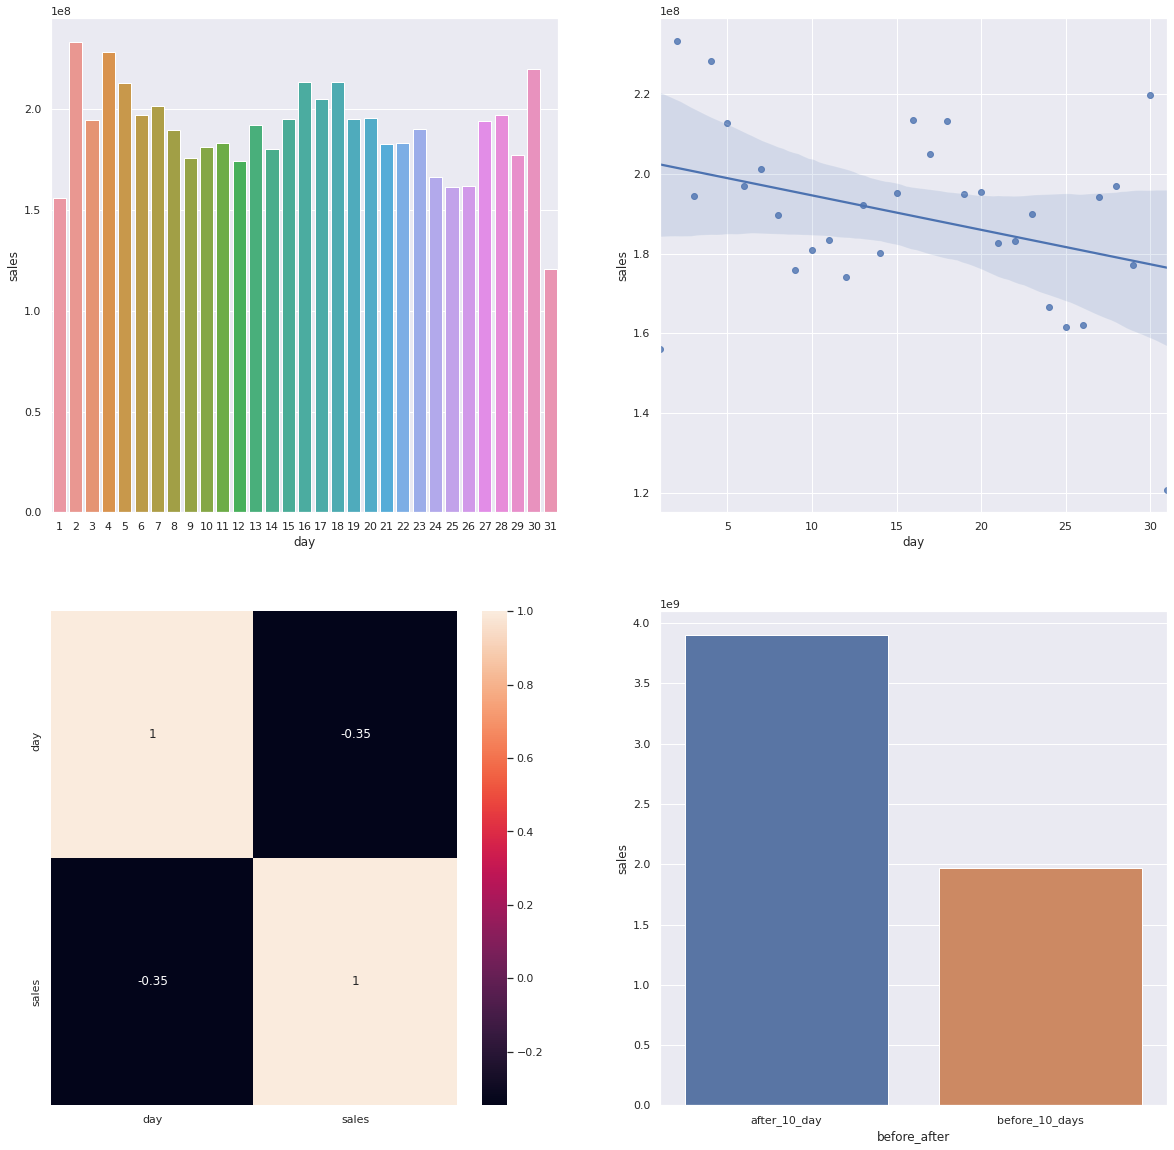

In [39]:
aux1 = df4[['day','sales']].groupby('day').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x='day', y='sales', data=aux1)

plt.subplot(2,2,2)
sns.regplot(x='day', y='sales', data=aux1)

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

aux1['before_after'] = aux1['day'].apply(lambda x : 'before_10_days' if x<= 10 else 'after_10_day')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

plt.subplot(2,2,4)
sns.barplot(x='before_after', y='sales', data=aux2)

#### H11 - Lojas deveriam vender menos aos finais de semana
**VERDADEIRA** Lojas vendem menos aos finais de semana

<AxesSubplot:>

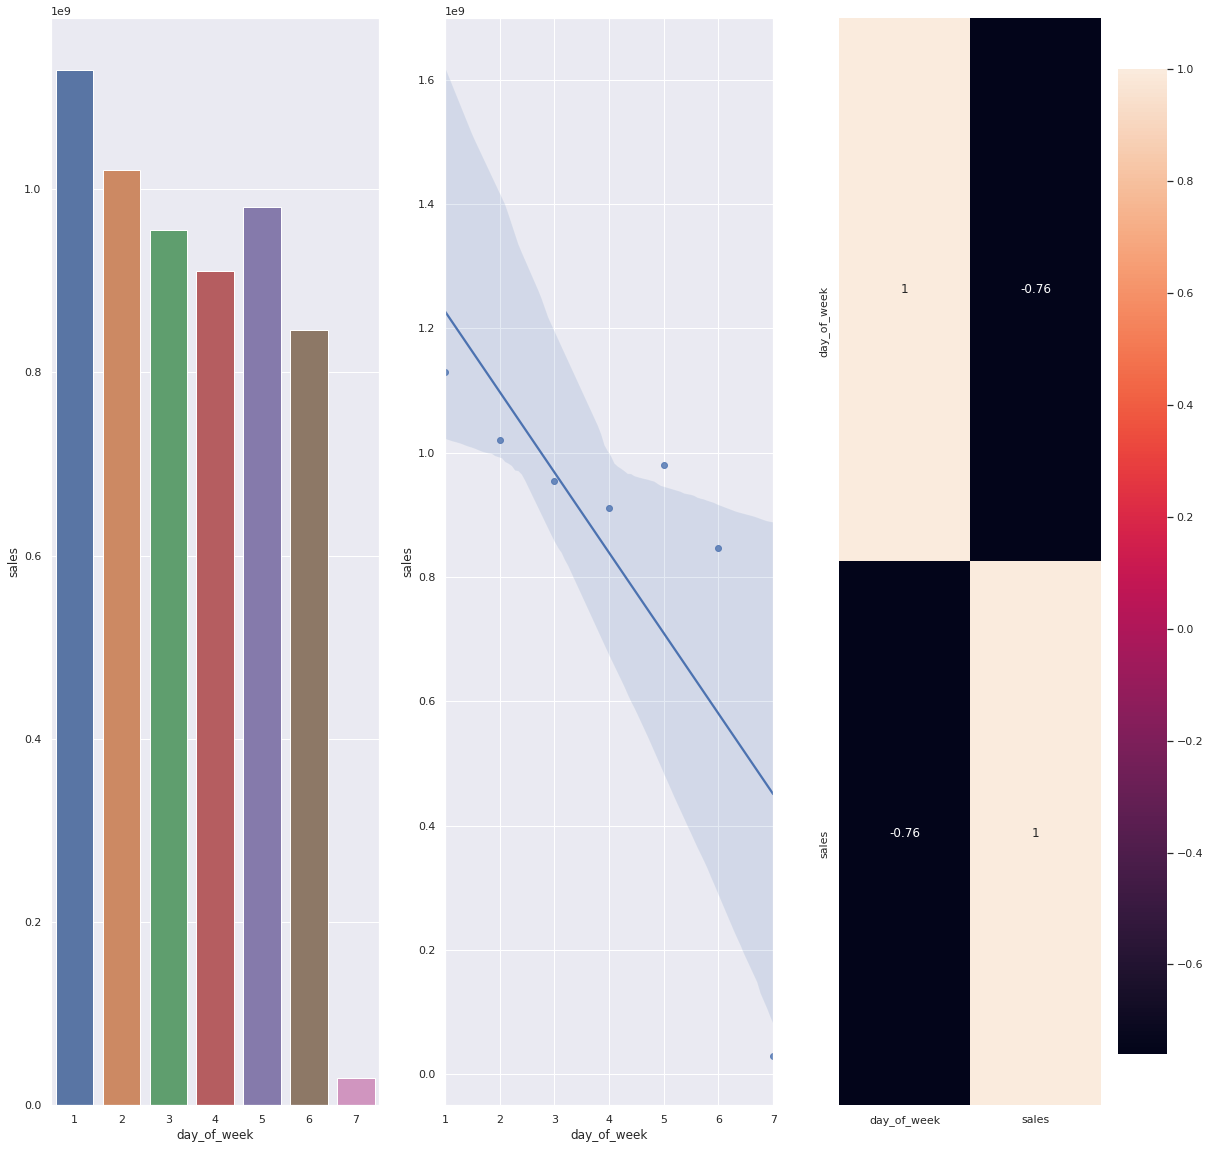

In [40]:
aux1 = df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='day_of_week', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.regplot(x='day_of_week', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

#### H12 - Lojas deveriam vender menos durante os feriados escolares
**VERDADEIRA** Lojas vendem menos durante os feriados escolares, exceto os meses de julho e agosto

<AxesSubplot:xlabel='month', ylabel='sales'>

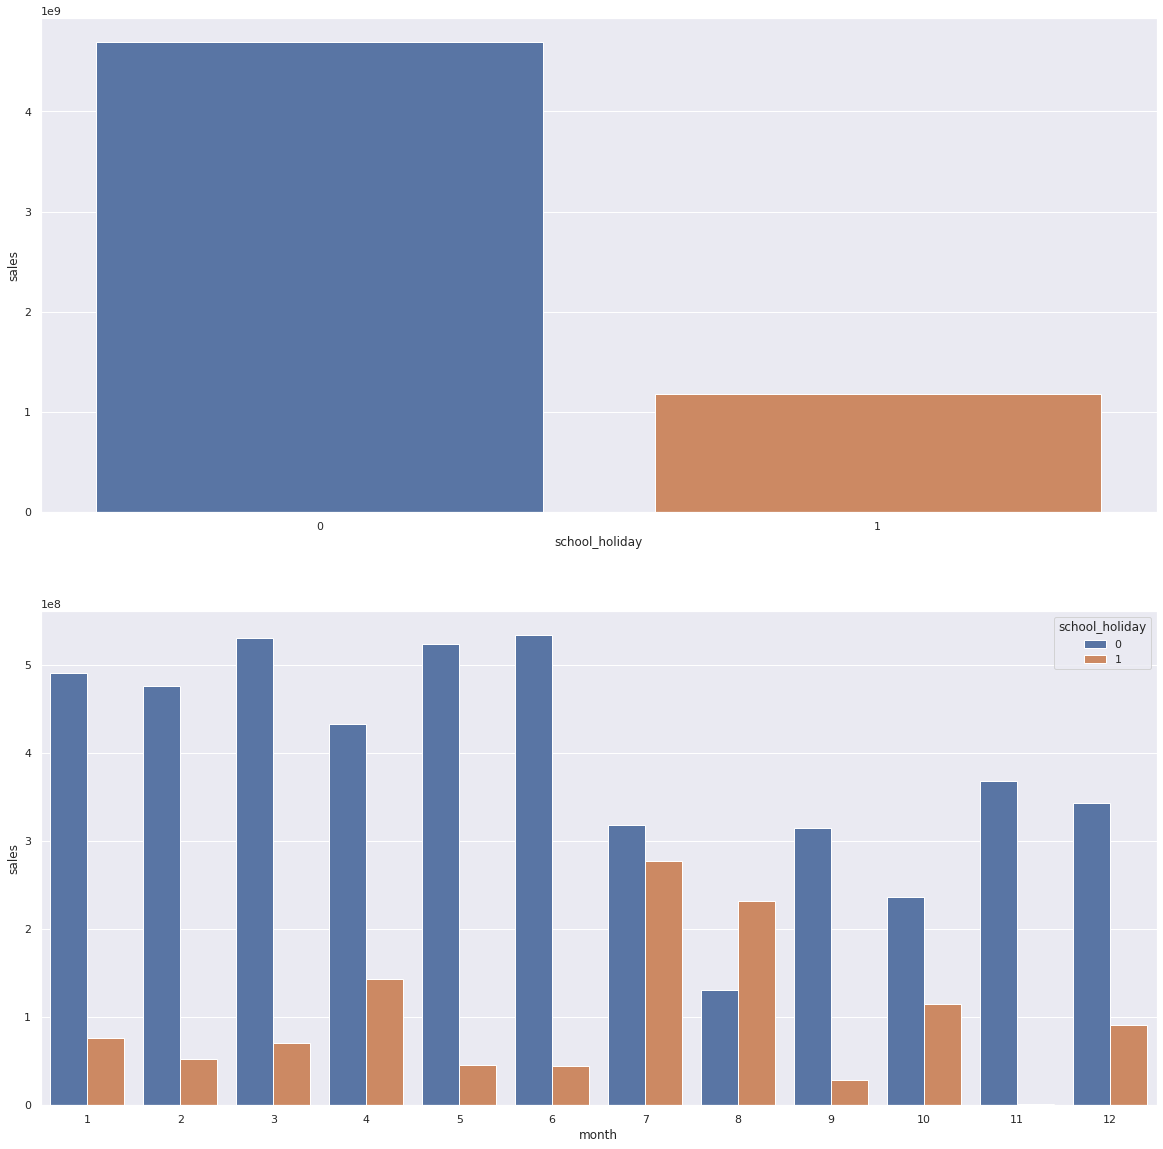

In [41]:
aux1 = df4[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()

plt.subplot(2,1,1)
sns.barplot(x='school_holiday', y='sales', data=aux1)

plt.subplot(2,1,2)
aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2)


### 4.3 Análise multivariada

#### Atributos numericos

<AxesSubplot:>

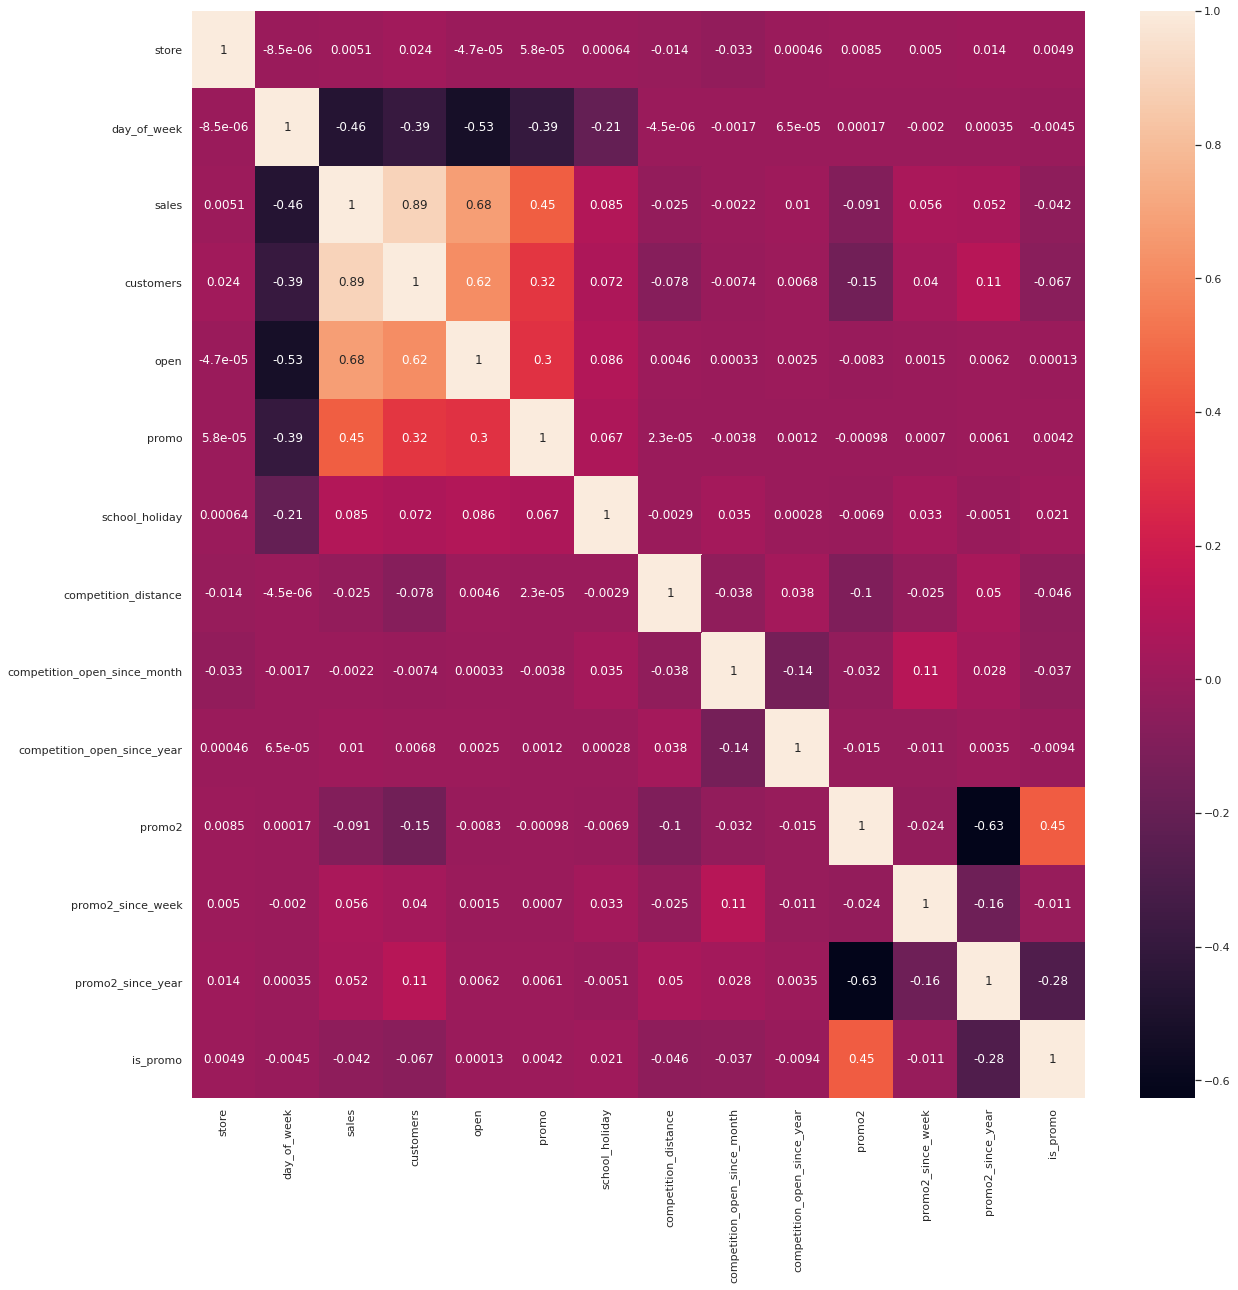

In [42]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True)

#### Atributos categóricos

In [43]:
a = df4.select_dtypes(include='object')

In [44]:
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

d = pd.DataFrame({'state_holiday':[a1,a2,a3], 'store_type':[a4,a5,a6], 'assortment':[a7,a8,a9]})

d = d.set_index(d.columns)

<AxesSubplot:>

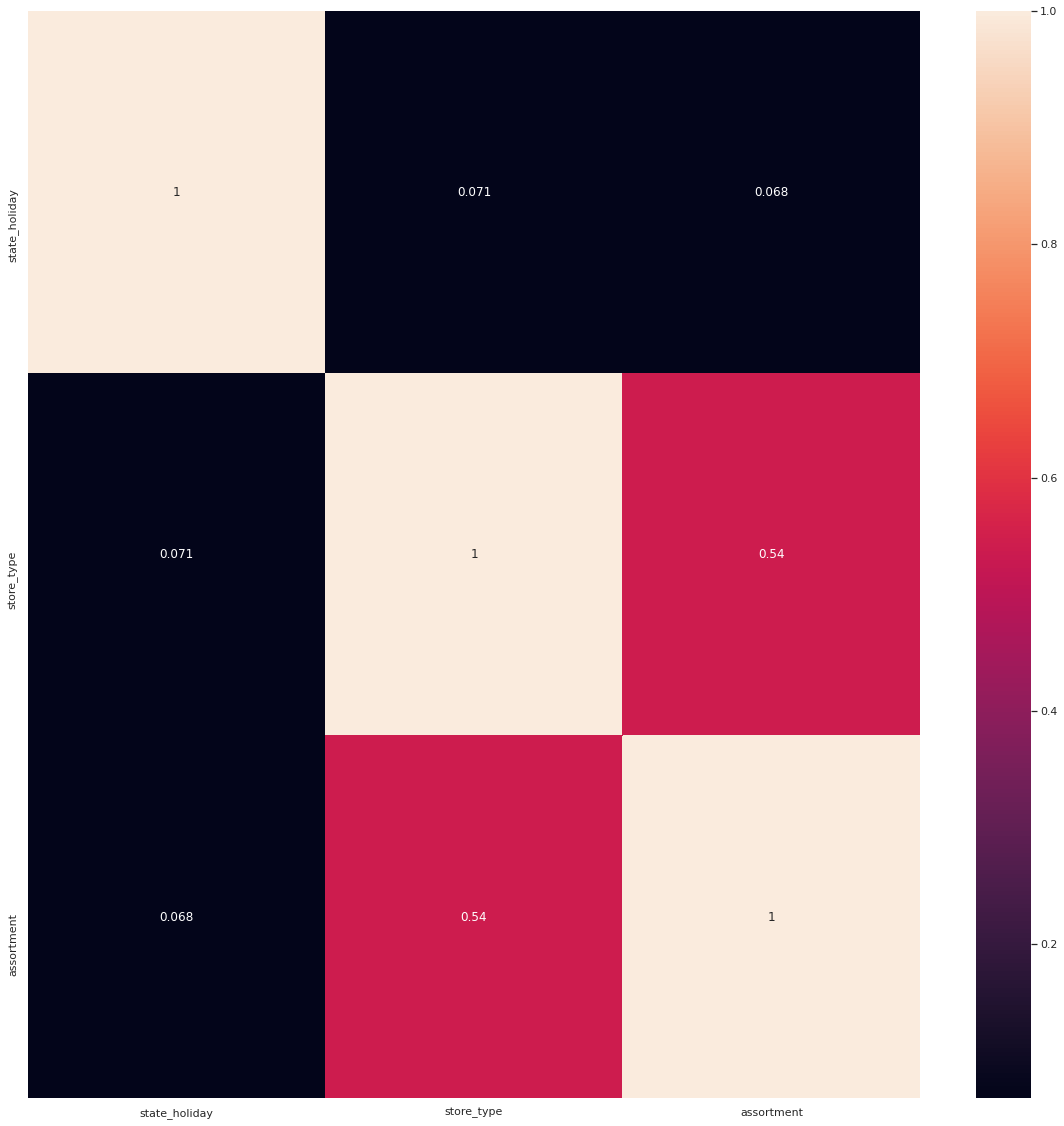

In [45]:
sns.heatmap(d, annot=True)

# 5.0 Data Preparation

In [30]:
df5 = df4.copy()
df5.head()

store  day_of_week       date  sales  promo state_holiday  school_holiday store_type assortment  competition_distance  competition_open_since_month  competition_open_since_year  promo2  promo2_since_week  promo2_since_year  is_promo  year  month  day  week_of_year year_week competition_since  competition_time_month promo_since  promo_time_week
0      1            5 2015-07-31   5263      1   regular_day               1          c      basic                1270.0                             9                         2008       0                 31               2015         0  2015      7   31            31   2015-30        2008-09-01                      84  2015-07-27                0
1      2            5 2015-07-31   6064      1   regular_day               1          a      basic                 570.0                            11                         2007       1                 13               2010         1  2015      7   31            31   2015-30        2007-11-01                      94  2010-03-22              279
2      3            5 2015-07-31   8314      1   regular_day               1          a      basic               14130.0                            12                         2006       1                 14               2011         1  2015      7   31            31   2015-30        2006-12-01                     105  2011-03-28              226
3      4            5 2015-07-31  13995      1   regular_day               1          c     extend                 620.0                             9                         2009       0                 31               2015         0  2015      7   31            31   2015-30        2009-09-01                      71  2015-07-27                0
4      5            5 2015-07-31   4822      1   regular_day               1          a      basic               29910.0                             4                         2015       0                 31               2015         0  2015      7   31            31   2015-30        2015-04-01                       4  2015-07-27                0

### 5.1 Nomalização

In [31]:
# não possuimos váriaveis com distribuição normal (ver análise univariada)

### 5.2 Rescaling

In [32]:
a = df5.select_dtypes(include=['int64', 'float64'])

In [33]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
pickle.dump(rs, open('/media/jrverza/JRVERZA_PEN/ds_producao/ds_producao/parameters/competition_distance_scaler.pkl', 'wb'))

# competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
pickle.dump(rs, open('/media/jrverza/JRVERZA_PEN/ds_producao/ds_producao/parameters/competition_time_month_scaler.pkl', 'wb'))

# promo time week - Não tem tantos outliers
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
pickle.dump(rs, open('/media/jrverza/JRVERZA_PEN/ds_producao/ds_producao/parameters/promo_time_week_scaler.pkl', 'wb'))

# year
df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump(mms, open('/media/jrverza/JRVERZA_PEN/ds_producao/ds_producao/parameters/year_scaler.pkl', 'wb'))


### 5.3 Transformação 

#### Encoding

In [34]:
df5.head()

store  day_of_week       date  sales  promo state_holiday  school_holiday store_type assortment  competition_distance  competition_open_since_month  competition_open_since_year  promo2  promo2_since_week  promo2_since_year  is_promo  year  month  day  week_of_year year_week competition_since  competition_time_month promo_since  promo_time_week
0      1            5 2015-07-31   5263      1   regular_day               1          c      basic             -0.170968                             9                         2008       0                 31               2015         0   1.0      7   31            31   2015-30        2008-09-01                0.918919  2015-07-27         0.287016
1      2            5 2015-07-31   6064      1   regular_day               1          a      basic             -0.283871                            11                         2007       1                 13               2010         1   1.0      7   31            31   2015-30        2007-11-01                1.054054  2010-03-22         0.922551
2      3            5 2015-07-31   8314      1   regular_day               1          a      basic              1.903226                            12                         2006       1                 14               2011         1   1.0      7   31            31   2015-30        2006-12-01                1.202703  2011-03-28         0.801822
3      4            5 2015-07-31  13995      1   regular_day               1          c     extend             -0.275806                             9                         2009       0                 31               2015         0   1.0      7   31            31   2015-30        2009-09-01                0.743243  2015-07-27         0.287016
4      5            5 2015-07-31   4822      1   regular_day               1          a      basic              4.448387                             4                         2015       0                 31               2015         0   1.0      7   31            31   2015-30        2015-04-01               -0.162162  2015-07-27         0.287016

In [35]:
# state holiday - One hot encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns = ['state_holiday'])

# store type - Label encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump(le, open('/media/jrverza/JRVERZA_PEN/ds_producao/ds_producao/parameters/store_type_scaler.pkl', 'wb'))

# assortment - Ordinal encoding
assortment_dict = {'basic':1, 'extra':2, 'extend':3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

#### Transformação da váriavel resposta

In [36]:
df5['sales'] = np.log1p(df5['sales'])

#### Transformação de natureza

In [37]:
# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x*(2*np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x*(2*np.pi/12)))

In [38]:
# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x*(2*np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x*(2*np.pi/30)))

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x*(2*np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x*(2*np.pi/52)))

# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x*(2*np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x*(2*np.pi/7)))

# 6.0 Feature Selection

In [39]:
df6=df5.copy()

### 6.1 Divisão do dataset em treino e teste

In [40]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis=1)

In [41]:
# como nossa vendas dependem do tempo, não podemos divir os dataset aleatoriamente
df6[['store','date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

In [42]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
Y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
Y_test = X_test['sales']

print('training min date: {}'.format(X_train['date'].min()))
print('training max date: {}'.format(X_train['date'].max()))

print('\ntraining min date: {}'.format(X_test['date'].min()))
print('training max date: {}'.format(X_test['date'].max()))

training min date: 2013-01-01 00:00:00
training max date: 2015-06-18 00:00:00

training min date: 2015-06-19 00:00:00
training max date: 2015-07-31 00:00:00


In [43]:
df6.isna().sum()

store                           0
date                            0
sales                           0
promo                           0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
is_promo                        0
year                            0
competition_time_month          0
promo_time_week                 0
state_holiday_christmas         0
state_holiday_easter_holiday    0
state_holiday_public_holiday    0
state_holiday_regular_day       0
month_sin                       0
month_cos                       0
day_sin                         0
day_cos                         0
week_of_year_sin                0
week_of_year_cos                0
day_of_week_sin                 0
day_of_week_cos                 0
dtype: int64

### 6.2 Boruta como Feature Selector

In [44]:
# training dataset
#X_train_n = X_train.drop(['date', 'sales'], axis=1).values
#Y_train_n = Y_train.values.ravel()

## define Randon Forest
#rf = RandomForestRegressor(n_jobs=1)
#
## define Botura
#boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, Y_train_n)

In [45]:
#cols_selected = boruta.support_.tolist()
#
# best features from boruta
#X_train_fs = X_train.drop(['date', 'sales'], axis=1)
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()
#
# not selected from boruta
#cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

### 6.3 Manual feature selection from Boruta results

In [46]:
# comparar as colunas selecionadas pelo boruta com as hipoteses (bivariada) e ver se faz sentido

cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

# final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

In [47]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos']

# 7.0 Machine learning modelling

In [48]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

# time series data preparation
x_training = X_train[cols_selected_boruta_full]

### 7.1 Average Model

In [87]:
aux1 = x_test.copy()
aux1['sales'] = Y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns = {'sales': 'predictions'})
aux1 = pd.merge(aux1,aux2,how='left',on='store')
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error('Average Model', np.expm1(Y_test), np.expm1(yhat_baseline))
baseline_result

model name          MAE    MAPE         RMSE
0  Average Model  1354.800353  0.2064  1835.135542

### 7.2 Linear Regression Model

In [88]:
# model
lr = LinearRegression().fit(x_train, Y_train)

# prediction
yhat_lr = lr.predict(x_test)

# performance - lembrar de voltar os valores convertidos em log para valores verdadeiros com exponencial
lr_result = ml_error('Linear Regression', np.expm1(Y_test), np.expm1(yhat_lr))
lr_result

model name          MAE      MAPE         RMSE
0  Linear Regression  1867.089774  0.292694  2671.049215

#### Linear Regression Model - cross validation

In [89]:
lr_result_cv = cross_validation(x_training,5, 'Linear Regression', lr, verbose=False)
lr_result_cv

Model Name              MAE CV       MAPE CV             RMSE CV
0  Linear Regression  2081.73 +/- 295.63  0.3 +/- 0.02  2952.52 +/- 468.37

### 7.3 Linear Regression Regularized Model

In [90]:
# model
lrr = Lasso(alpha=0.01).fit(x_train, Y_train)

# prediction
yhat_lrr = lrr.predict(x_test)

# performance - lembrar de voltar os valores convertidos em log para valores verdadeiros com exponencial
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(Y_test), np.expm1(yhat_lrr))
lrr_result

model name          MAE      MAPE         RMSE
0  Linear Regression - Lasso  1891.704881  0.289106  2744.451737

#### Linear Regression Regularized Model - cross validation

In [91]:
lrr_result_cv = cross_validation(x_training, 5, 'Linear Regression Regularized', lrr, verbose=False)
lrr_result_cv

Model Name             MAE CV        MAPE CV             RMSE CV
0  Linear Regression Regularized  2116.38 +/- 341.5  0.29 +/- 0.01  3057.75 +/- 504.26

### 7.4 Random Forest Regressor

In [92]:
# model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, Y_train)

# prediction
yhat_rf = rf.predict(x_test)

# performance - lembrar de voltar os valores convertidos em log para valores verdadeiros com exponencial
rf_result = ml_error('Random Forest Regressor', np.expm1(Y_test), np.expm1(yhat_rf))
rf_result

model name         MAE      MAPE         RMSE
0  Random Forest Regressor  679.080548  0.099879  1010.101738

#### Random Forest Regressor - cross validation

In [93]:
rf_result_cv = cross_validation(x_training,5, 'Random Forest Regressor', rf, verbose=False)
rf_result_cv

Model Name            MAE CV        MAPE CV             RMSE CV
0  Random Forest Regressor  837.7 +/- 219.24  0.12 +/- 0.02  1256.59 +/- 320.28

### 7.5 XGBoost Regressor

In [66]:
# model
xgb_model = xgb.XGBRegressor(objective = 'reg:squarederror', n_estimators=100, eta=0.01, max_depth =10,
                         subsample = 0.7, colsample_bytree = 0.9).fit(x_train, Y_train)

# prediction
yhat_xgb = xgb_model.predict(x_test)

# performance - lembrar de voltar os valores convertidos em log para valores verdadeiros com exponencial
xgb_result = ml_error('XGBoost Regressor', np.expm1(Y_test), np.expm1(yhat_xgb))
xgb_result

model name        MAE      MAPE         RMSE
0  XGBoost Regressor  6683.6739  0.949475  7330.979785

#### XGBoost Regressor - cross validation

In [67]:
xgb_result_cv = cross_validation(x_training,5, 'XGBoost Regressor', xgb_model, verbose=False)
xgb_result_cv

Model Name              MAE CV       MAPE CV            RMSE CV
0  XGBoost Regressor  7049.16 +/- 588.44  0.95 +/- 0.0  7715.2 +/- 689.21

### 7.6 Comparação entre os modelos

#### Single performance

In [96]:
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values('RMSE')

model name          MAE      MAPE         RMSE
0    Random Forest Regressor   679.080548  0.099879  1010.101738
0              Average Model  1354.800353  0.206400  1835.135542
0          Linear Regression  1867.089774  0.292694  2671.049215
0  Linear Regression - Lasso  1891.704881  0.289106  2744.451737
0          XGBoost Regressor  6683.673900  0.949475  7330.979785

#### Real performance

In [97]:
modelling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modelling_result_cv

Model Name              MAE CV        MAPE CV             RMSE CV
0              Linear Regression  2081.73 +/- 295.63   0.3 +/- 0.02  2952.52 +/- 468.37
0  Linear Regression Regularized   2116.38 +/- 341.5  0.29 +/- 0.01  3057.75 +/- 504.26
0        Random Forest Regressor    837.7 +/- 219.24  0.12 +/- 0.02  1256.59 +/- 320.28
0              XGBoost Regressor  7049.16 +/- 588.44   0.95 +/- 0.0   7715.2 +/- 689.21

# 8.0 Hyperparameter Fine Tuning

### 8.1 Random Search

#### XGBoost

In [ ]:
#param = {
#    'n_estimators': [500, 1700, 2500, 3000, 3500],
#    'eta':[0.01,0.03],
#    'max_depth':[3,5,9],
#    'subsample':[0.1,0.5,0.7],
#    'colsample_bytree':[0.3,0.7,0.9],
#    'min_child_weight':[3,8,15]
#}

#max_eval = 2

In [107]:
#final_result = pd.DataFrame()
#
#for i in range(max_eval):
#    # escolher valores para os parametros aleatoriamente
#    hp = {k:random.sample(v,1)[0] for k, v in param.items()}
#    print(hp)
#    
#    # model
#    xgb_model = xgb.XGBRegressor(objective = 'reg:squarederror', 
#                                 n_estimators=hp['n_estimators'], 
#                                 eta=hp['eta'], 
#                                 max_depth =hp['max_depth'], 
#                                 subsample = hp['subsample'], 
#                                 colsample_bytree = hp['colsample_bytree'],
#                                 min_child_weight=hp['min_child_weight'])
#
#    # performance - lembrar de voltar os valores convertidos em log para valores verdadeiros com exponencial
#    result = cross_validation(x_training, 2, 'XGBoost Regressor', xgb_model, verbose=False)
#    final_result = pd.concat([final_result, result])
#    
#final_result

In [51]:
#param_tuned = {
#    'n_estimators':3000,
#    'eta':0.03,
#    'max_depth':5,
#    'subsample':0.7,
#    'colsample_bytree':0.7,
#    'min_child_weight':3
#}
#
#
## model
#xgb_model_tuned = xgb.XGBRegressor(objective = 'reg:squarederror', 
#                             n_estimators=param_tuned['n_estimators'], 
#                             eta=param_tuned['eta'], 
#                             max_depth =param_tuned['max_depth'], 
#                             subsample = param_tuned['subsample'], 
#                             colsample_bytree = param_tuned['colsample_bytree'],
#                             min_child_weight=param_tuned['min_child_weight']).fit(x_train, Y_train)
# prediction
yhat_xgb_tuned = xgb_model_tuned.predict(x_test)

# performance
xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(Y_test), np.expm1(yhat_xgb_tuned))
xgb_result_tuned

model name         MAE      MAPE         RMSE
0  XGBoost Regressor  769.418442  0.115452  1103.863993

In [70]:
# saved trained model
pickle.dump(xgb_model_tuned, open('/media/jrverza/JRVERZA_PEN/ds_producao/ds_producao/model/model_xgb_rossman.pkl', 'wb'))

#### Random Forest

In [ ]:
param = {'n_estimators': [15, 17, 25, 30, 35]}

max_eval = 2

In [108]:
final_result = pd.DataFrame()

for i in range(max_eval):
    # escolher valores para os parametros aleatoriamente
    hp = {k:random.sample(v,1)[0] for k, v in param.items()}
    print(hp)
    
    # model
    rf = RandomForestRegressor(n_estimators=hp['n_estimators'], n_jobs=-1, random_state=42)

    # performance 
    result = cross_validation(x_training, 2, 'Random Forest Regressor', rf, verbose=False)
    final_result = pd.concat([final_result, result])
    
final_result

{'n_estimators': 35}
{'n_estimators': 17}


Model Name            MAE CV        MAPE CV             RMSE CV
0  Random Forest Regressor  782.99 +/- 77.42   0.1 +/- 0.01  1164.48 +/- 150.36
0  Random Forest Regressor   797.6 +/- 71.47  0.11 +/- 0.01   1184.4 +/- 140.52

In [109]:
# aplicando os melhores parâmetros encontrados
param_tuned = {'n_estimators':35}

In [50]:
# model
#rf_tuned = RandomForestRegressor(n_estimators=param_tuned['n_estimators'], n_jobs=-1, random_state=42).fit(x_train, Y_train)

# prediction
yhat_rf_tuned = rf_tuned.predict(x_test)

# performance - lembrar de voltar os valores convertidos em log para valores verdadeiros com exponencial
rf_result_tuned = ml_error('Random Forest Regressor', np.expm1(Y_test), np.expm1(yhat_rf_tuned))
rf_result_tuned

model name         MAE      MAPE         RMSE
0  Random Forest Regressor  686.244931  0.100909  1022.091151

In [ ]:
# saved trained model
pickle.dump(rf_tuned, open('/media/jrverza/JRVERZA_PEN/ds_producao/ds_producao/model/model_rossman.pkl', 'wb'))

# 9.0 Tradução e interpretação do erro

In [52]:
xgb_model_tuned = pickle.load(open('/media/jrverza/JRVERZA_PEN/ds_producao/ds_producao/model/model_xgb_rossman.pkl', 'rb'))

In [53]:
df9 = X_test[cols_selected_boruta_full]

# rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

### 9.1 Business Performance

In [54]:
# sum of prediction
df91 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAPE'})

# merge 
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store')
df92=pd.merge(df91, df9_aux3, how='inner', on='store')

# scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# order columns 
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [55]:
df92.sort_values('MAPE', ascending=False).head()

store    predictions  worst_scenario  best_scenario          MAE      MAPE
291    292  106171.351562   102781.272397  109561.430728  3390.079166  0.587557
908    909  222328.015625   214455.375870  230200.655380  7872.639755  0.518544
901    902  198744.593750   197370.631757  200118.555743  1373.961993  0.341750
169    170  202679.281250   201303.897177  204054.665323  1375.384073  0.338774
875    876  197616.000000   193510.122442  201721.877558  4105.877558  0.335593

<AxesSubplot:xlabel='store', ylabel='MAPE'>

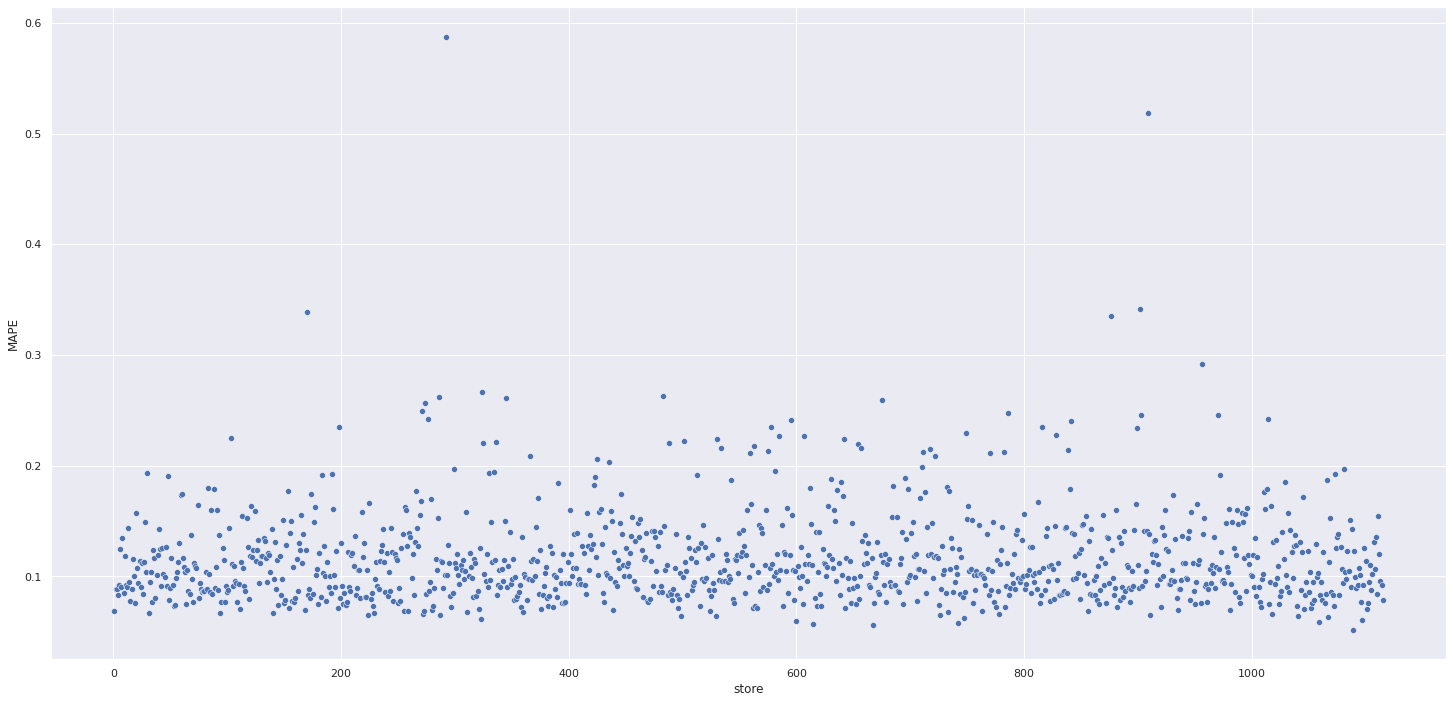

In [56]:
sns.scatterplot(x='store', y='MAPE', data=df92)

### 9.2 Total Performance

In [57]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns={'index':'scenario', 0:'values'})
df93['values'] = df93['values'].map('R${:,.2f}'.format)
df93

scenario            values
0     predictions  R$286,304,320.00
1  worst_scenario  R$285,443,146.28
2   best_scenario  R$287,165,461.67

### 9.3 Machine Learning Performance 

In [58]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

<AxesSubplot:xlabel='predictions', ylabel='error'>

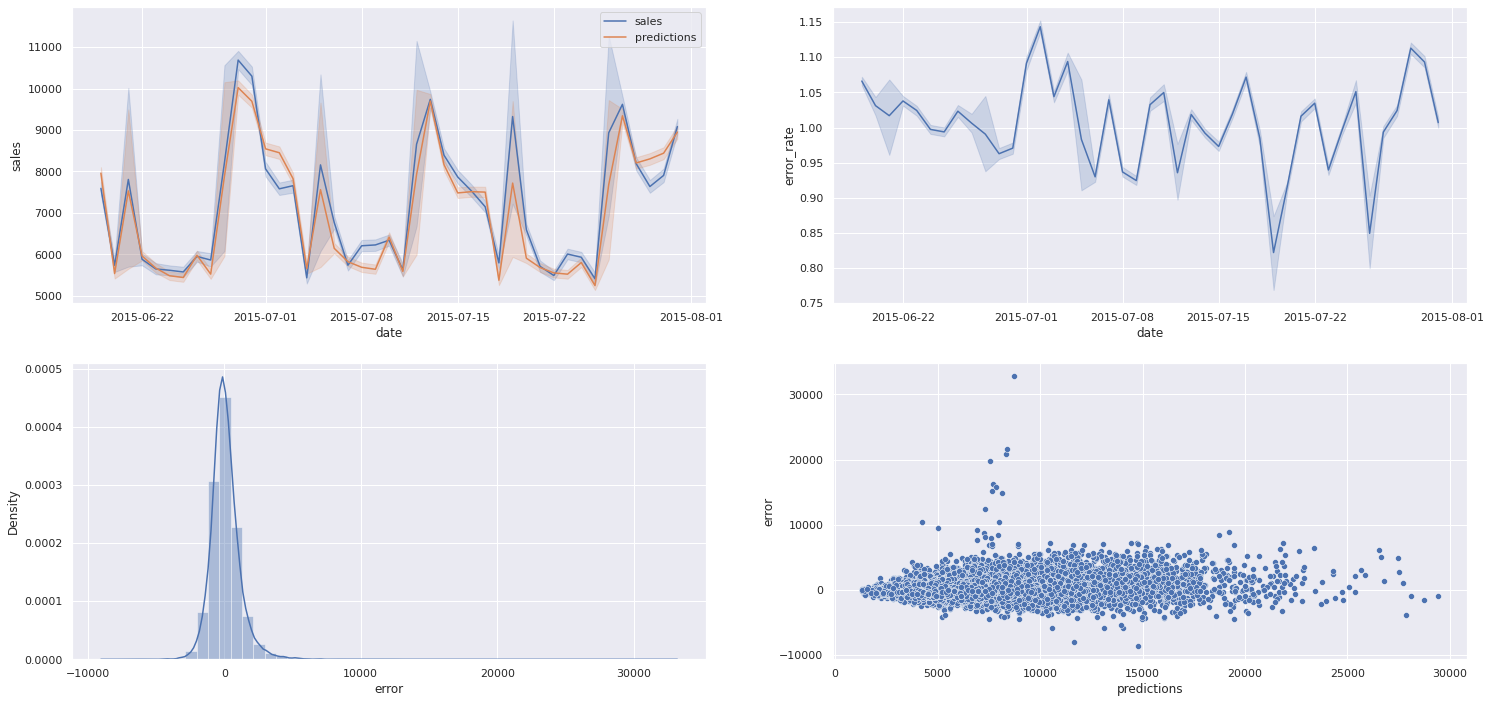

In [59]:
plt.subplot(2,2,1)
sns.lineplot(x='date', y='sales', data=df9, label='sales')
sns.lineplot(x='date', y='predictions', data=df9, label='predictions')

plt.subplot(2,2,2)
sns.lineplot(x='date', y='error_rate', data=df9)

plt.subplot(2,2,3)
sns.distplot(df9['error'])

plt.subplot(2,2,4)
sns.scatterplot(df9['predictions'], df9['error'])

# 10.0 Deploy model to production

### 10.1 Rossman class

In [60]:
class Rossman(object):
    def __init__(self):
        self.competition_distance_scaler = pickle.load(open('/media/jrverza/JRVERZA_PEN/ds_producao/ds_producao/parameters/competition_distance_scaler.pkl', 'rb'))
        self.competition_time_month_scaler = pickle.load(open('/media/jrverza/JRVERZA_PEN/ds_producao/ds_producao/parameters/competition_time_month_scaler.pkl', 'rb'))
        self.promo_time_week_scaler = pickle.load(open('/media/jrverza/JRVERZA_PEN/ds_producao/ds_producao/parameters/promo_time_week_scaler.pkl', 'rb'))
        self.year_scaler = pickle.load(open('/media/jrverza/JRVERZA_PEN/ds_producao/ds_producao/parameters/year_scaler.pkl', 'rb'))
        self.store_type_scaler = pickle.load(open('/media/jrverza/JRVERZA_PEN/ds_producao/ds_producao/parameters/store_type_scaler.pkl', 'rb'))
        state = 1
    
    def data_cleaning (self, df1):
        # renomeando as colunas 
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 
            'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
            'StoreType', 'Assortment','CompetitionDistance',
            'CompetitionOpenSinceMonth','CompetitionOpenSinceYear', 
            'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

        # renomeando as colunas com snakecase
        snakecase = lambda x: inflection.underscore(x)
        cols_new = list(map(snakecase,cols_old))
        df1.columns=cols_new
        
        # chance data type
        df1['date'] = pd.to_datetime(df1['date'])
        
        # fill NA
        # competition_distance
        df1['competition_distance']= df1['competition_distance'].apply(lambda x: 200000 if math.isnan(x) else x)

        # competition_open_since_month 
        df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

        # competition_open_since_year 
        df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

        # promo2_since_week 
        df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

        # promo2_since_year
        df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

        # promo_interval
        month_map = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',
                 7: 'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}

        df1['promo_interval'].fillna(0, inplace=True)

        df1['month_map'] = df1['date'].dt.month.map(month_map)

        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval']==0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)
        
        # chance data types
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)

        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

        df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)

        df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)
        
        return df1
        
        
    def feature_engineering(self, df2):
        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day 
        df2['day'] = df2['date'].dt.day

        # week of ywar
        df2['week_of_year'] = df2['date'].dt.weekofyear

        # year week
        df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

        # competition since
        df2['competition_since'] = df2.apply( lambda x: datetime.datetime(year = x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)

        df2['competition_time_month']= ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)

        df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x+'-1', '%Y-%W-%w') - datetime.timedelta(days=7))

        df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

        # assortment
        df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x=='a' else 'extra' if x=='b' else 'extend')

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x=='a' else 'easter_holiday' if x=='b' else 'christmas' if x=='c' else 'regular_day') 
        
        # filtragem das linhas
        df2 = df2[(df2['open'] != 0) & (df2['sales'] > 0)]
        
        # seleção das colunas
        cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
        df2 = df2.drop(cols_drop, axis=1)
        
        return df2
        
        
    def data_preparation(self,df5):
        # rescaling
        # competition distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform(df5[['competition_distance']].values)
        

        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform(df5[['competition_time_month']].values)
        

        # promo time week - Não tem tantos outliers
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform(df5[['promo_time_week']].values)
        
        # year
        df5['year'] = self.year_scaler.fit_transform(df5[['year']].values)


        #encoding
        # state holiday - One hot encoding
        df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns = ['state_holiday'])

        # store type - Label encoding
        df5['store_type'] = self.store_type_scaler.fit_transform(df5['store_type'])
        

        # assortment - Ordinal encoding
        assortment_dict = {'basic':1, 'extra':2, 'extend':3}
        df5['assortment'] = df5['assortment'].map(assortment_dict)
        
        # tranformações de natureza
        # month
        df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x*(2*np.pi/12)))
        df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x*(2*np.pi/12)))

        # day
        df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x*(2*np.pi/30)))
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x*(2*np.pi/30)))

        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x*(2*np.pi/52)))
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x*(2*np.pi/52)))

        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x*(2*np.pi/7)))
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x*(2*np.pi/7)))
        
            
        cols_selected = ['store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month', 'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month', 'promo_time_week', 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos']
        
        
        return df5[cols_selected]

### 10.2 API Handler

In [61]:
from flask import Flask, request, Response
from rossman.Rossman import Rossman

import pandas as pd
import pickle

# loadin model
model = pickle.load(open('/media/jrverza/JRVERZA_PEN/ds_producao/ds_producao/model/model_xgb_rossman.pkl', 'rb'))

# iniciando a API
app = Flask(__name__)

@app.route('/rossman/predict', method=['POST'])
def rossman_predict():
    test_json = request.get_json()
    
    if test_json: # se tiver dados 
        if isinstance(test_json, dict): # se o dado for uma linha
            test_raw = pd.DataFrame(test_json, index=[0])
        else:
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys()) # se o dados for mais que uma linha
        
        # instanciando a rossman class
        pipeline = Rossman()
        
        # data cleaning
        df1 = pipeline.data_cleaning(test_raw)
        
        # feature engineering
        df2 = pipeline.feature_engineering(df1)
        
        # data preparation
        df3 = pipeline.data_preparation(df2)
        
        # predict
        df_response = pipeline.get_prediction(model,test_raw,df3)   
        
        return df_response
    
    else:
        return Reponse('{}', status=200, mimetype='application/json')
        
        
if __name__ == '__main__':
    app.run('0.0.0.0')
    

ModuleNotFoundError: No module named 'rossman'

### 10.3 API Tester

In [62]:
# loading test dataset
df10 = pd.read_csv('test.csv')

In [63]:
# merge test dataset + store dataset
df_test = pd.merge(df10, df_store_raw, how='left', on='Store')

# escolhendo uma loja para predição
#df_test = df_test[df_test['Store'] == 22]
df_test = df_test[df_test['Store'].isin([22,24,12])]

# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop('Id', axis=1)

In [64]:
# convert dataframe to json
import json
data = json.dumps(df_test.to_dict(orient = 'records'))

In [70]:
# API call
#url = 'http://0.0.0.0:5000/rossman/predict'
url = 'http://test-model-rossman-xgb.herokuapp.com/rossman/predict'
header = {'Content-type':'application/json'}
data = data

r = requests.post(url, data=data, headers=header)
print('status code {}'.format(r.status_code))

status code 200


In [71]:
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())

In [72]:
d1.head()

store  day_of_week                      date  open  promo state_holiday  school_holiday store_type assortment  competition_distance  competition_open_since_month  competition_open_since_year  promo2  promo2_since_week  promo2_since_year   promo_interval month_map  is_promo  year  month  day  week_of_year year_week         competition_since  competition_time_month               promo_since  promo_time_week   prediciton
0     12            4  2015-09-17T00:00:00.000Z   1.0      1   regular_day               0          a     extend                1070.0                             9                         2015       1                 13               2010  Jan,Apr,Jul,Oct       Sep         0  2015      9   17            38   2015-37  2015-09-01T00:00:00.000Z                       0  2010-03-22T00:00:00.000Z              286  6047.878906
1     22            4  2015-09-17T00:00:00.000Z   1.0      1   regular_day               0          a      basic                1040.0                             9                         2015       1                 22               2012  Jan,Apr,Jul,Oct       Sep         0  2015      9   17            38   2015-37  2015-09-01T00:00:00.000Z                       0  2012-05-21T00:00:00.000Z              173  3915.101562
2     24            4  2015-09-17T00:00:00.000Z   1.0      1   regular_day               0          a     extend                4590.0                             3                         2000       1                 40               2011  Jan,Apr,Jul,Oct       Sep         0  2015      9   17            38   2015-37  2000-03-01T00:00:00.000Z                     189  2011-09-26T00:00:00.000Z              207  7535.219238
3     12            3  2015-09-16T00:00:00.000Z   1.0      1   regular_day               0          a     extend                1070.0                             9                         2015       1                 13               2010  Jan,Apr,Jul,Oct       Sep         0  2015      9   16            38   2015-37  2015-09-01T00:00:00.000Z                       0  2010-03-22T00:00:00.000Z              286  6099.217773
4     22            3  2015-09-16T00:00:00.000Z   1.0      1   regular_day               0          a      basic                1040.0                             9                         2015       1                 22               2012  Jan,Apr,Jul,Oct       Sep         0  2015      9   16            38   2015-37  2015-09-01T00:00:00.000Z                       0  2012-05-21T00:00:00.000Z              173  3939.208252

In [73]:
d2 = d1[['store', 'prediciton']].groupby('store').sum().reset_index()

In [74]:
for i in range(len(d2)):
    print('Store number {} will sell R${:,.2f} in the next 6 weeks'.format(d2.loc[i,'store'], d2.loc[i,'prediciton']))

Store number 12 will sell R$227,112.73 in the next 6 weeks
Store number 22 will sell R$147,000.45 in the next 6 weeks
Store number 24 will sell R$287,007.71 in the next 6 weeks
